# 5강 - 실전예제2 - 대형마트 상품판매량 예측하기 (월마트, 매장별로 내일 얼마나 팔릴까?)

## 작성자 : AISchool ( http://aischool.ai/ )

**Data source** : https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting

**Reference** : https://www.kaggle.com/avelinocaio/walmart-store-sales-forecasting

# 1. 라이브러리 및 데이터 로드

In [25]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings   # 버전 충돌로 나오는 경고 표시를 표시하지 않게 설정 
warnings.filterwarnings('ignore')

# plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

In [2]:
features = pd.read_csv('./data/features.csv')  # feature 데이터 불러오기 
train = pd.read_csv('./data/train.csv')   # train 데이터 불러오기 
stores = pd.read_csv('./data/stores.csv')    # stores 데이터 불러오기 
test = pd.read_csv('./data/test.csv')   # test 데이터 불러오기 
sample_submission = pd.read_csv('./data/sampleSubmission.csv')  # 답안 작성용 데이터 불러오기 

# 2. Exploratory Data Analysis(EDA) & Data Cleansing

## feature.csv 데이터셋과 stores.csv 데이터셋을 merge해서 새로운 데이터셋(feat_sto)을 만듭니다. 이때 'Store' 컬럼을 키로 사용합니다.

In [3]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [4]:
feat_sto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [5]:
feat_sto.dtypes

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
dtype: object

> 'Date' 필드가 string(object) 타입으로 지정되어 있는 모습을 볼 수 있습니다. 우리는 이를 datetime 타입으로 변경할 수 있습니다.

In [6]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [8]:
test.dtypes

Store         int64
Dept          int64
Date         object
IsHoliday      bool
dtype: object

In [9]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

## 'Date'로부터 Week와 Year 컬럼을 새로 추가합니다.

In [10]:
feat_sto['Week'] = feat_sto.Date.dt.week
feat_sto['Year'] = feat_sto.Date.dt.year

In [11]:
feat_sto

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Week,Year
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315,5,2010
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315,6,2010
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315,7,2010
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315,8,2010
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False,B,118221,26,2013
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False,B,118221,27,2013
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False,B,118221,28,2013
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False,B,118221,29,2013


In [12]:
feat_sto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
 12  Type          8190 non-null   object        
 13  Size          8190 non-null   int64         
 14  Week          8190 non-null   int64         
 15  Year          8190 non-null   int64   

## train과 feat_sto, test와 feat_sto를 묶어서 train_detail, test_detail이라는 새로운 데이터 프레임을 생성합니다.

In [13]:
train_detail = train.merge(feat_sto, how='inner', on=['Store', 'Date', 'IsHoliday'])\
               .sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

In [14]:
test_detail = test.merge(feat_sto, how='inner', on=['Store', 'Date', 'IsHoliday'])\
               .sort_values(by=['Store', 'Dept', 'Date']).reset_index(drop=True)

In [15]:
train_detail.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,2010


In [16]:
test_detail.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,44,2012
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,45,2012
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,46,2012
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,47,2012
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315,48,2012


## 연도별 날짜별 판매량을 그래프로 살펴봅시다.

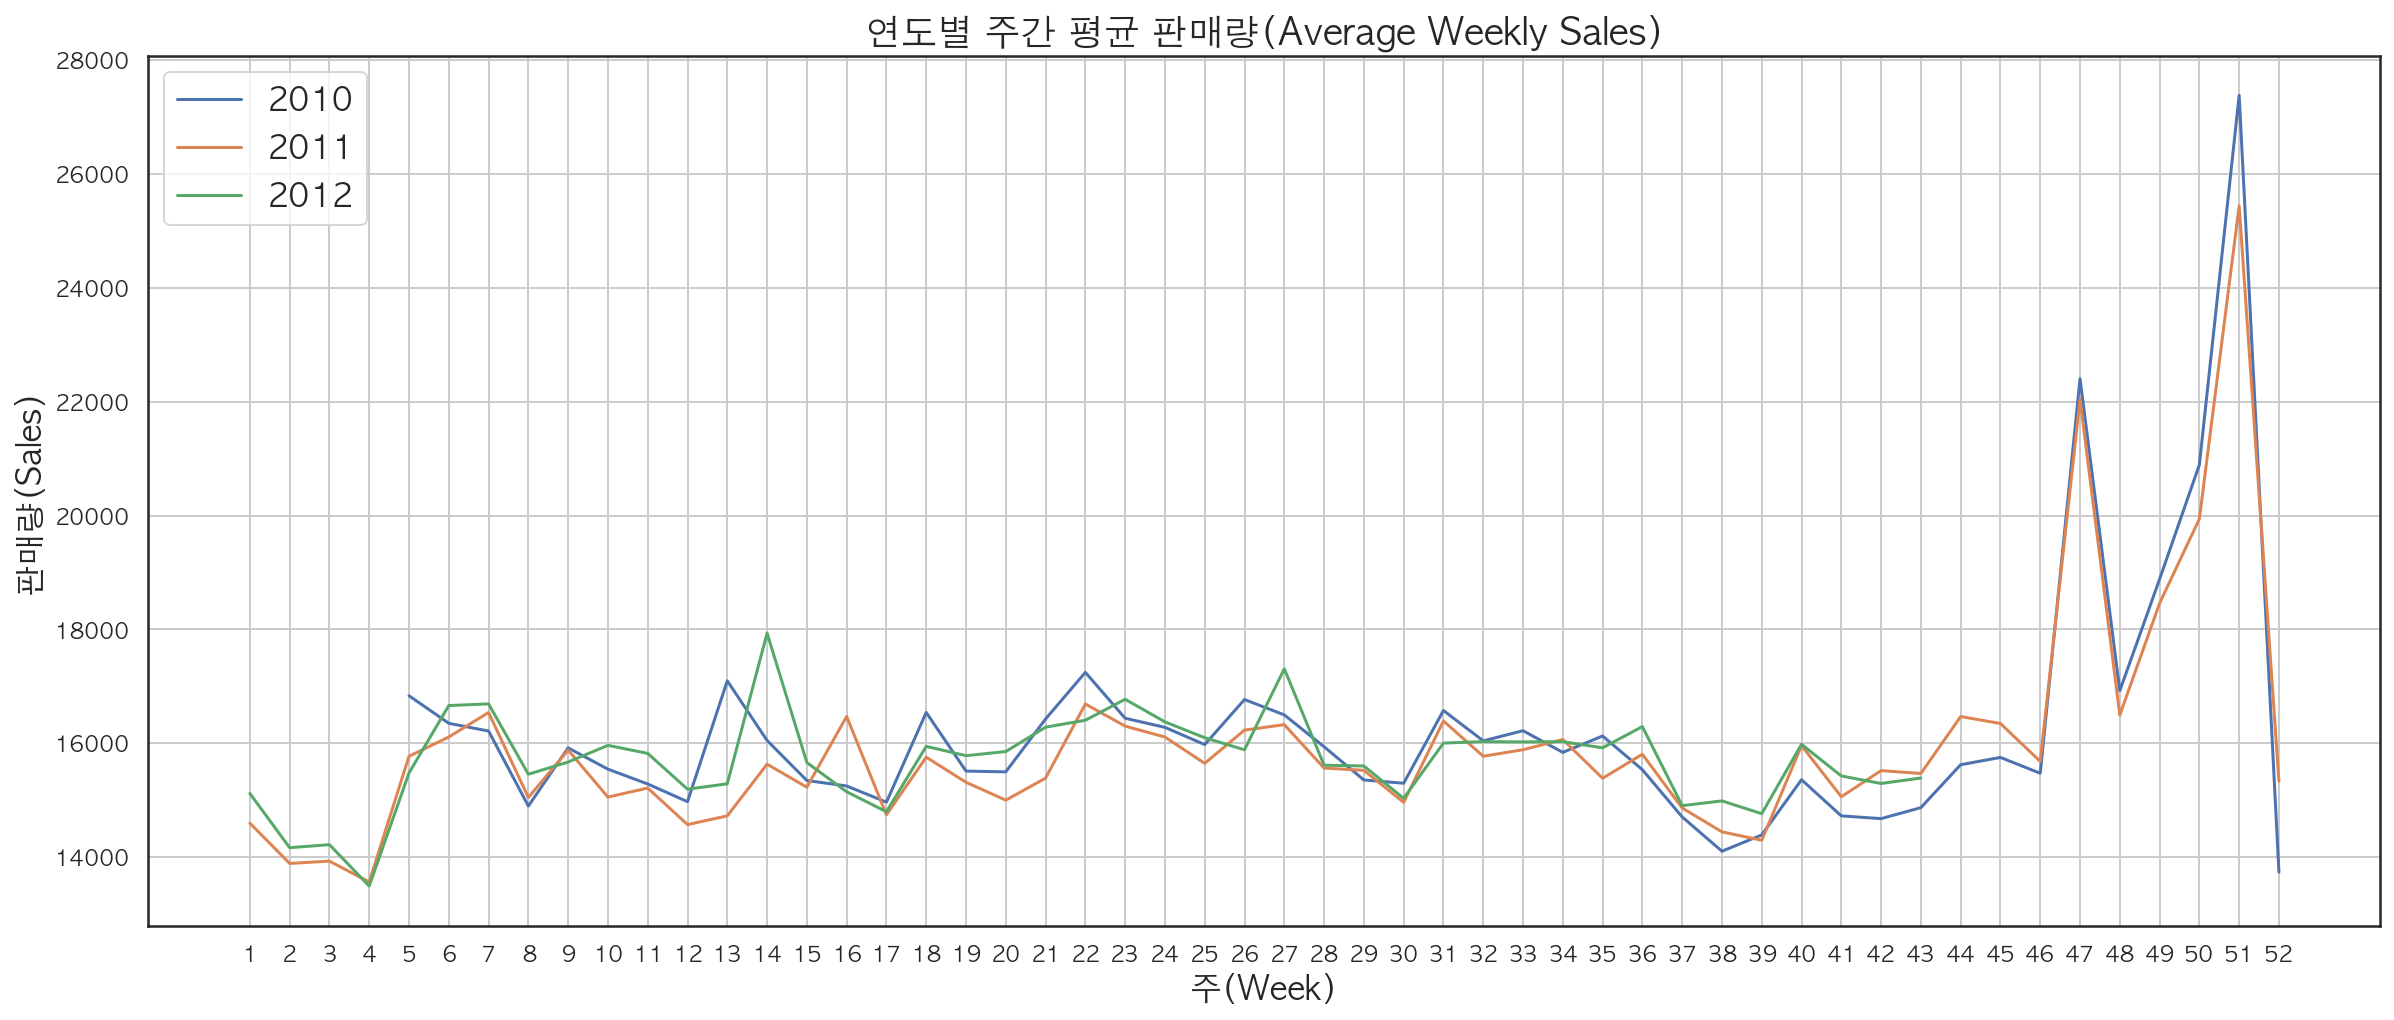

In [17]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()

# 그래프 출력 - lineplot
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)

plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('연도별 주간 평균 판매량(Average Weekly Sales)', fontsize=18)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('주(Week)', fontsize=16)
plt.show()

# 날짜별 판매량 평균값(Mean)과 중앙값(Median) 구해보기

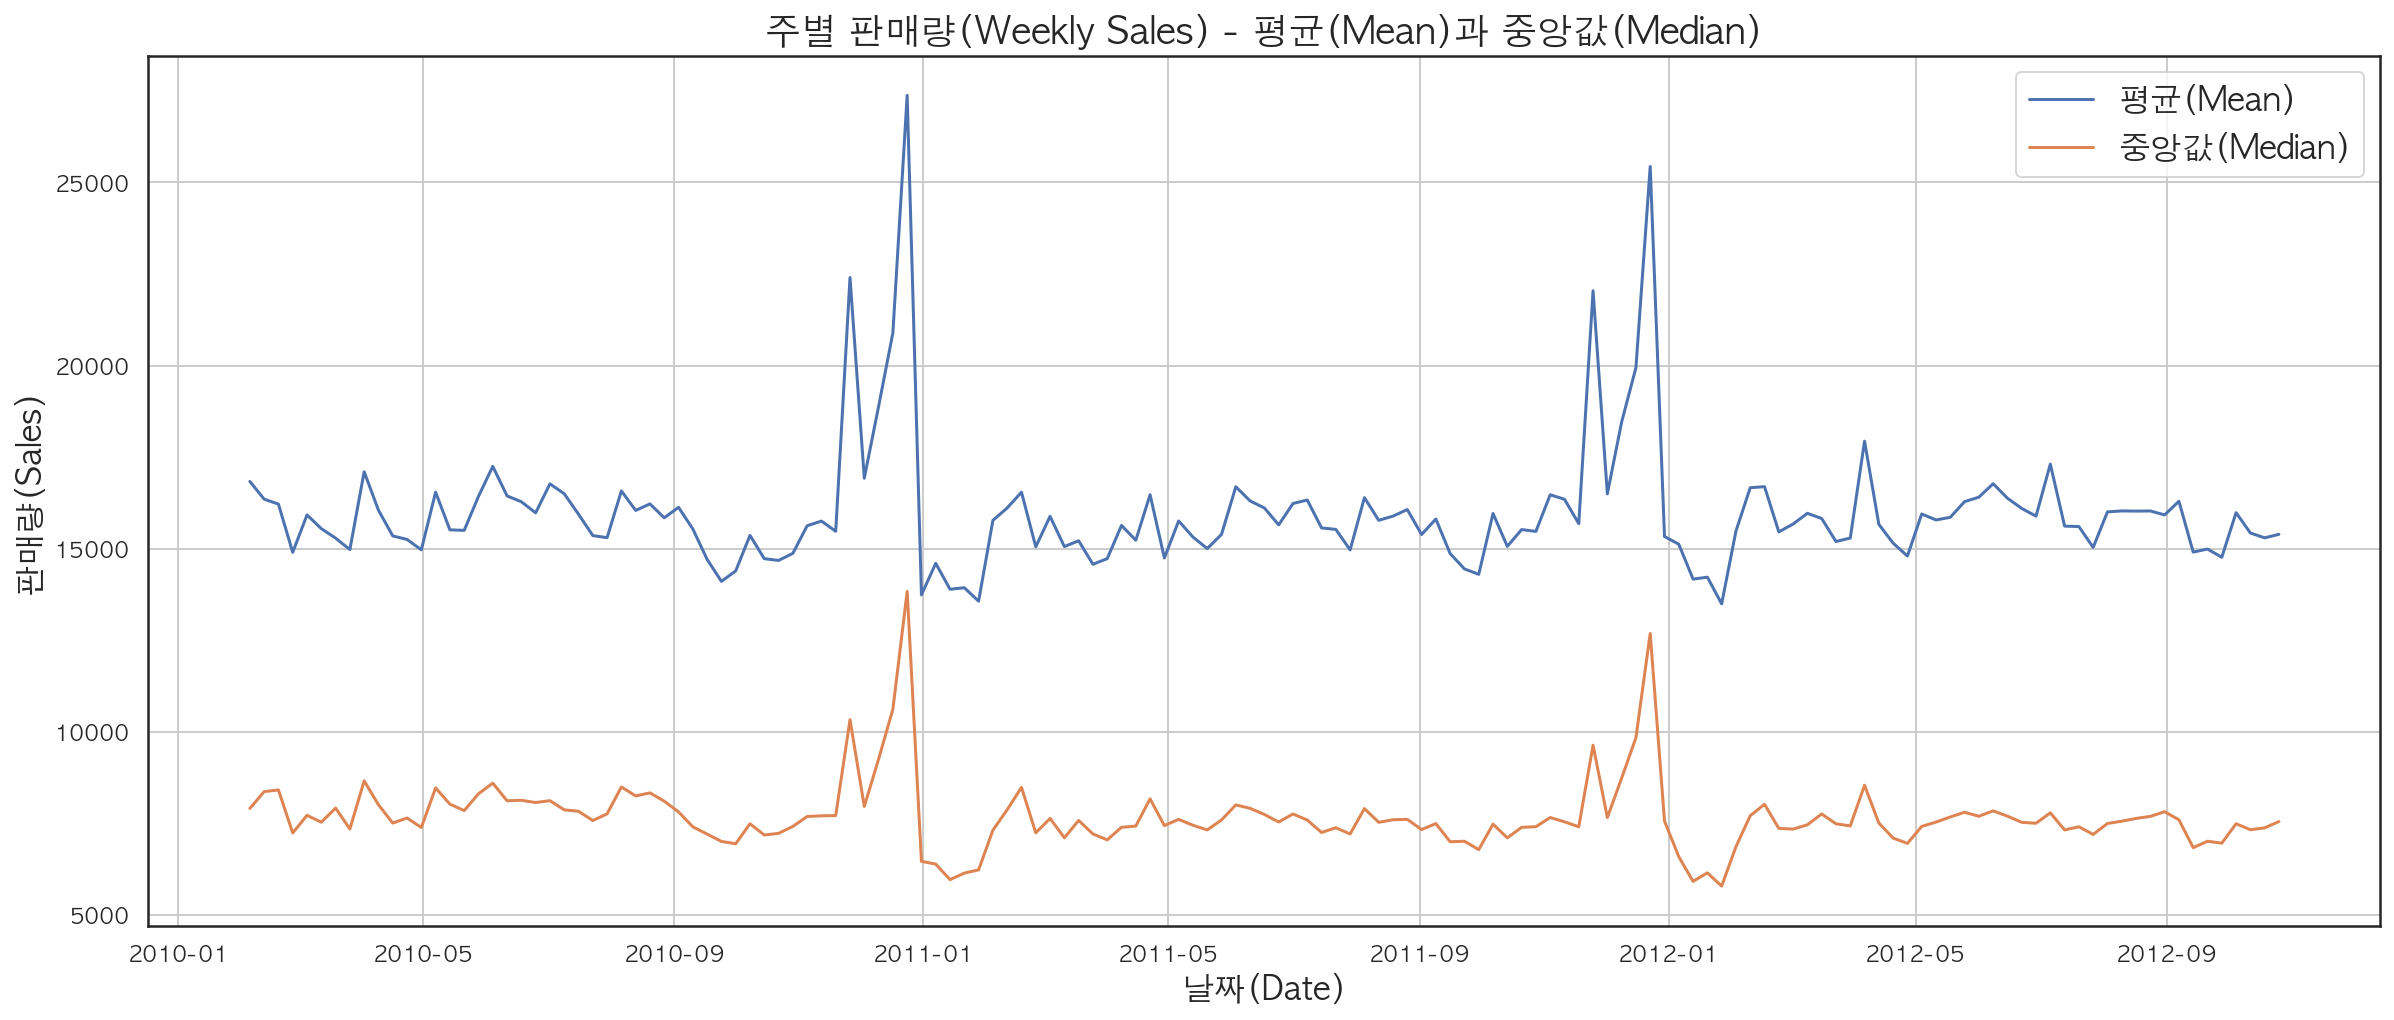

In [18]:
weekly_sales_mean = train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()

# 그래프 그리기 - lineplot
plt.figure(figsize=(20,8))
sns.lineplot(weekly_sales_mean.index, weekly_sales_mean.values)
sns.lineplot(weekly_sales_median.index, weekly_sales_median.values)

plt.grid()
plt.legend(['평균(Mean)', '중앙값(Median)'], loc='best', fontsize=16)
plt.title('주별 판매량(Weekly Sales) - 평균(Mean)과 중앙값(Median)', fontsize=18)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('날짜(Date)', fontsize=16)
plt.show()

## 위에서 볼 수 있듯이 평균값(mean)과 중앙값(median)이 매우 다른 모습을 볼 수 있습니다. 따라서 어떤 상점(store)/부서(department)는 다른 상점보다 훨씬 많이 판매한다는 사실을 알 수 있습니다.

# 상점(Store)와 부서(Department)별 평균 판매량(Average Sales)을 살펴봅시다.

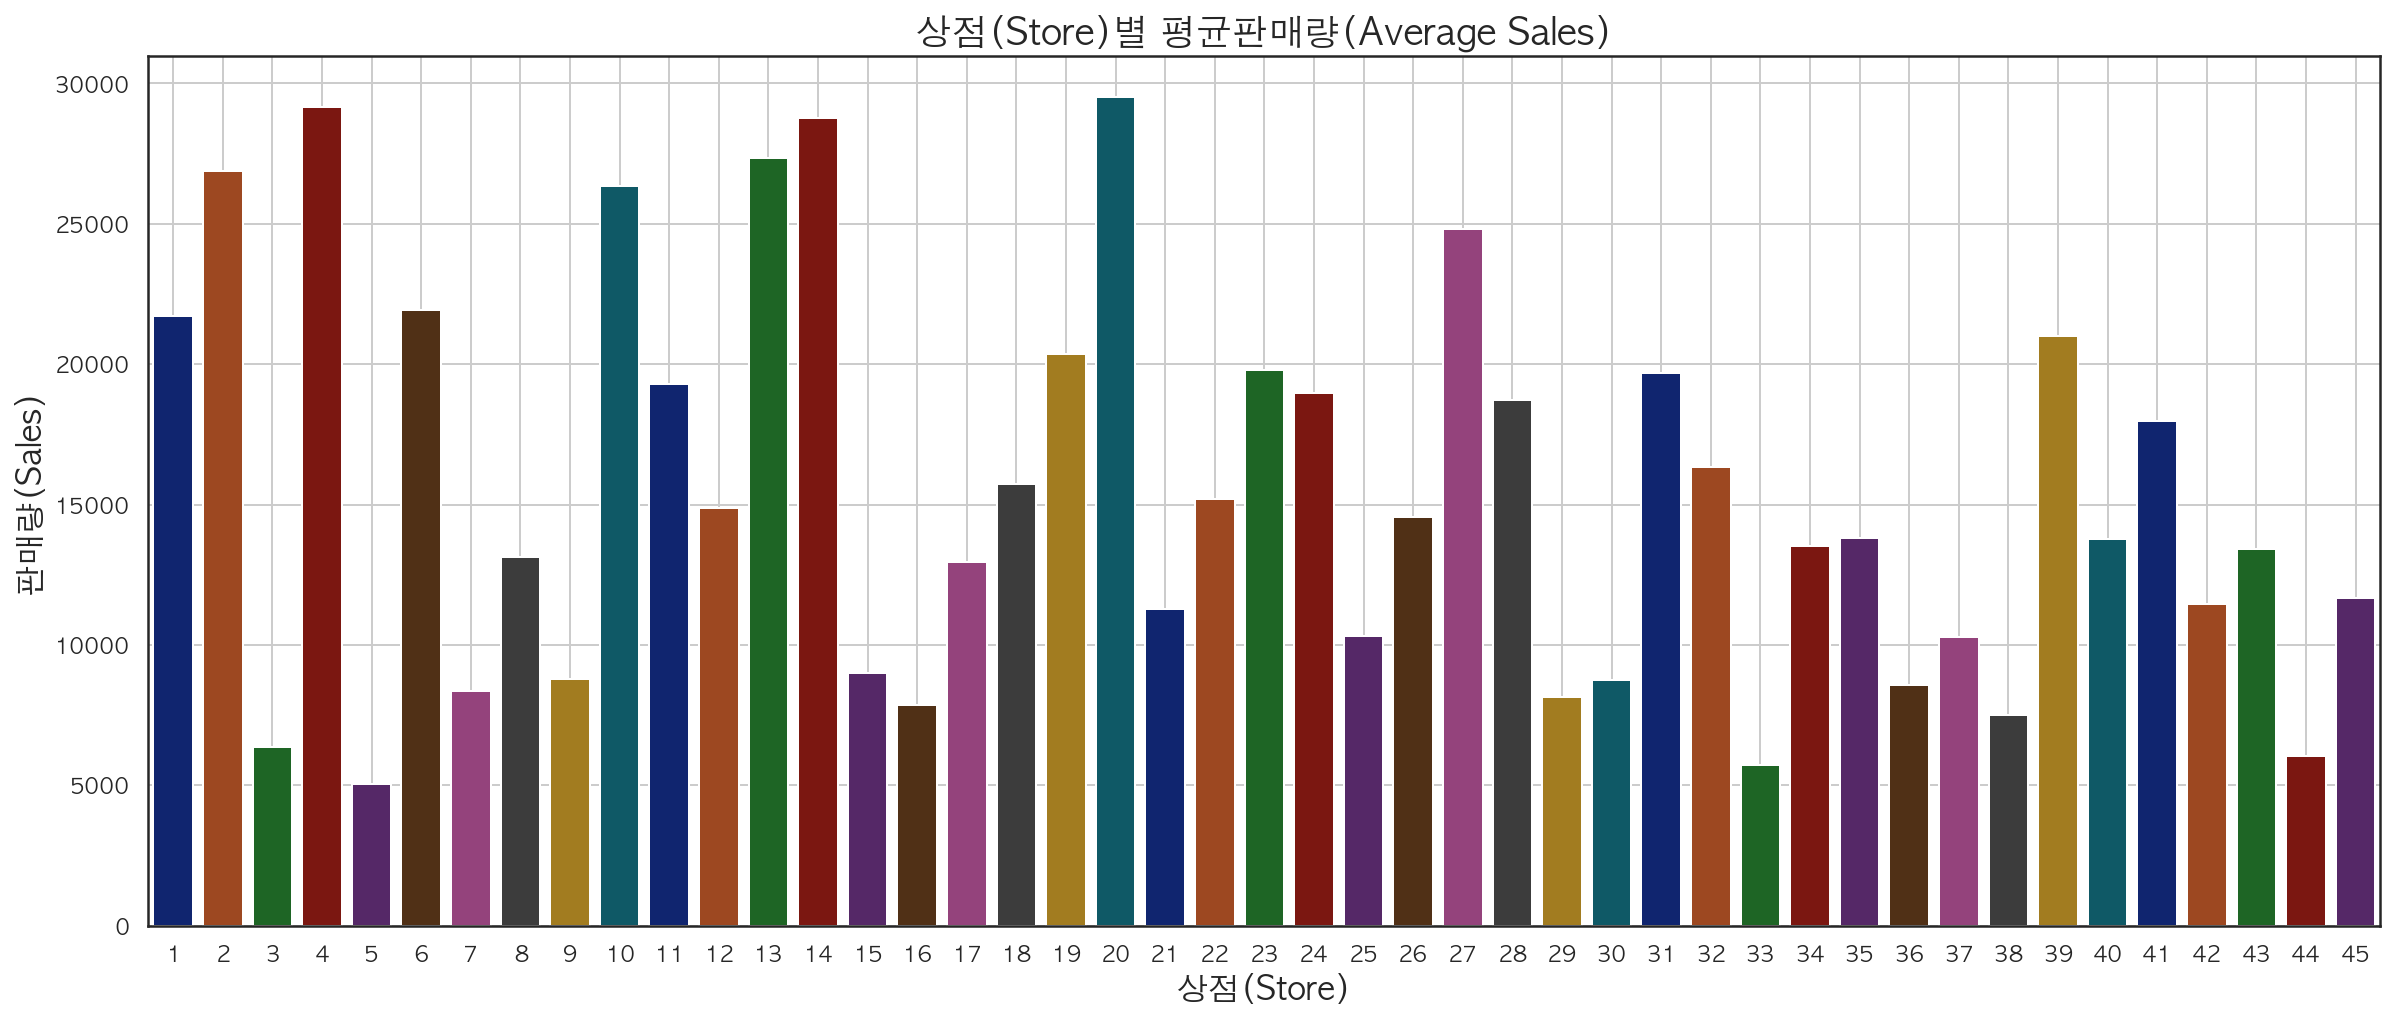

In [31]:
# 상점별 평균판매량 - Weekly_Salse 컬럼을 Sotre 평균값 기준 그룹바이 
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()

# 그래프 나타내기 - barplot
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('상점(Store)별 평균판매량(Average Sales)', fontsize=18)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('상점(Store)', fontsize=16)
plt.show()

## 상점별로 판매량이 다른 모습을 볼 수 있습니다.

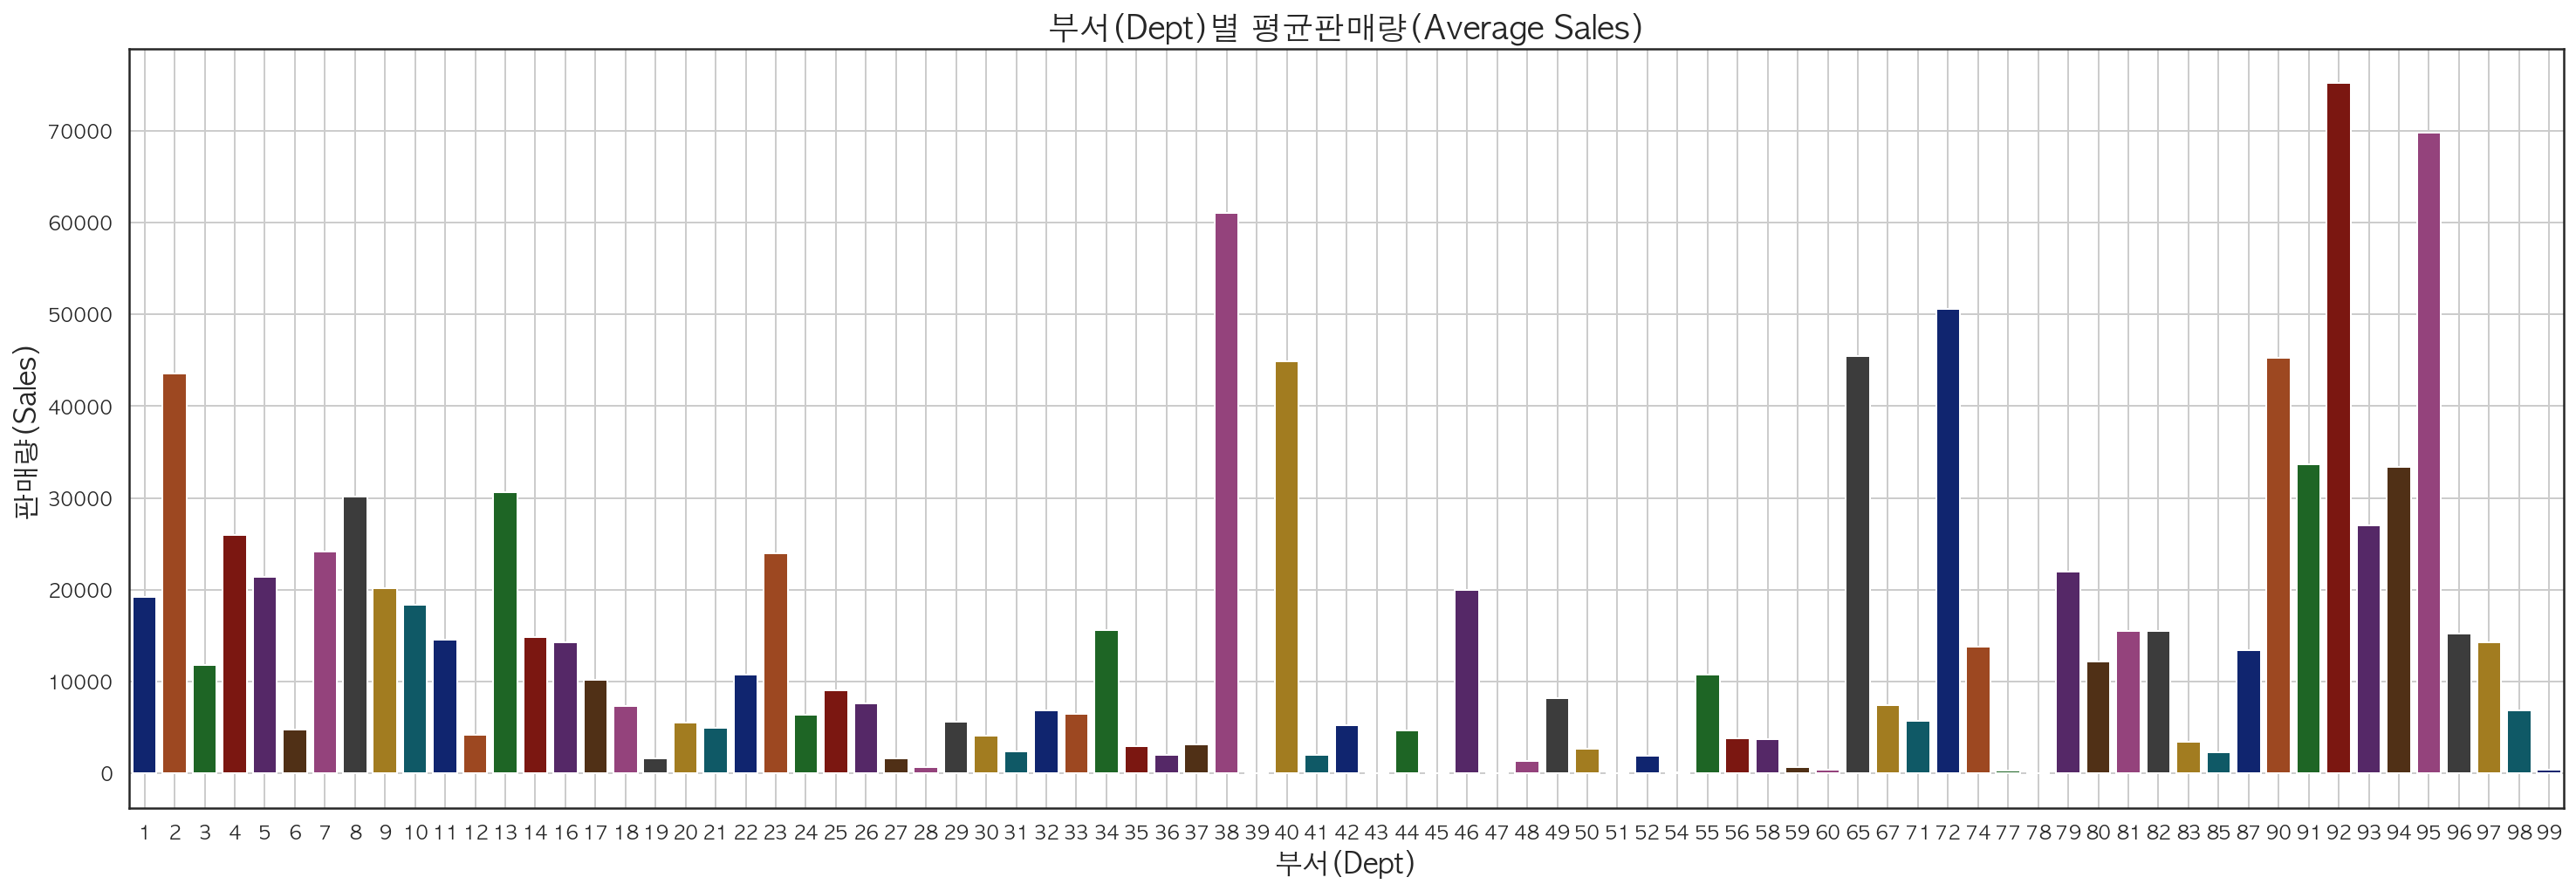

In [19]:
# 부서별 평균판매량 - Weekly_Salse 컬럼을 Dept 평균값 기준 그룹바이 
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()

# 그래프 나타내기 - barplot
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values, palette='dark')
plt.grid()
plt.title('부서(Dept)별 평균판매량(Average Sales)', fontsize=18)
plt.ylabel('판매량(Sales)', fontsize=16)
plt.xlabel('부서(Dept)', fontsize=16)
plt.show()

## 또한 부서(Dept)별로 판매량이 다른 모습을 관찰할 수 있습니다.

# 상관 분석(Correlation Analysis) 수행해보기

## 일반적으로 Correlation을 다음과 같이 해석합니다.
1. **0** : 전혀 연관관계가 없습니다.
2. **0-0.3** : 약간 연관관계를 갖고 있습니다.
3. **0.3-0.7** : 중간정도의 연관관계를 갖고 있습니다.
4. **0.7-1** : 강한 상관관계를 갖고 있습니다.

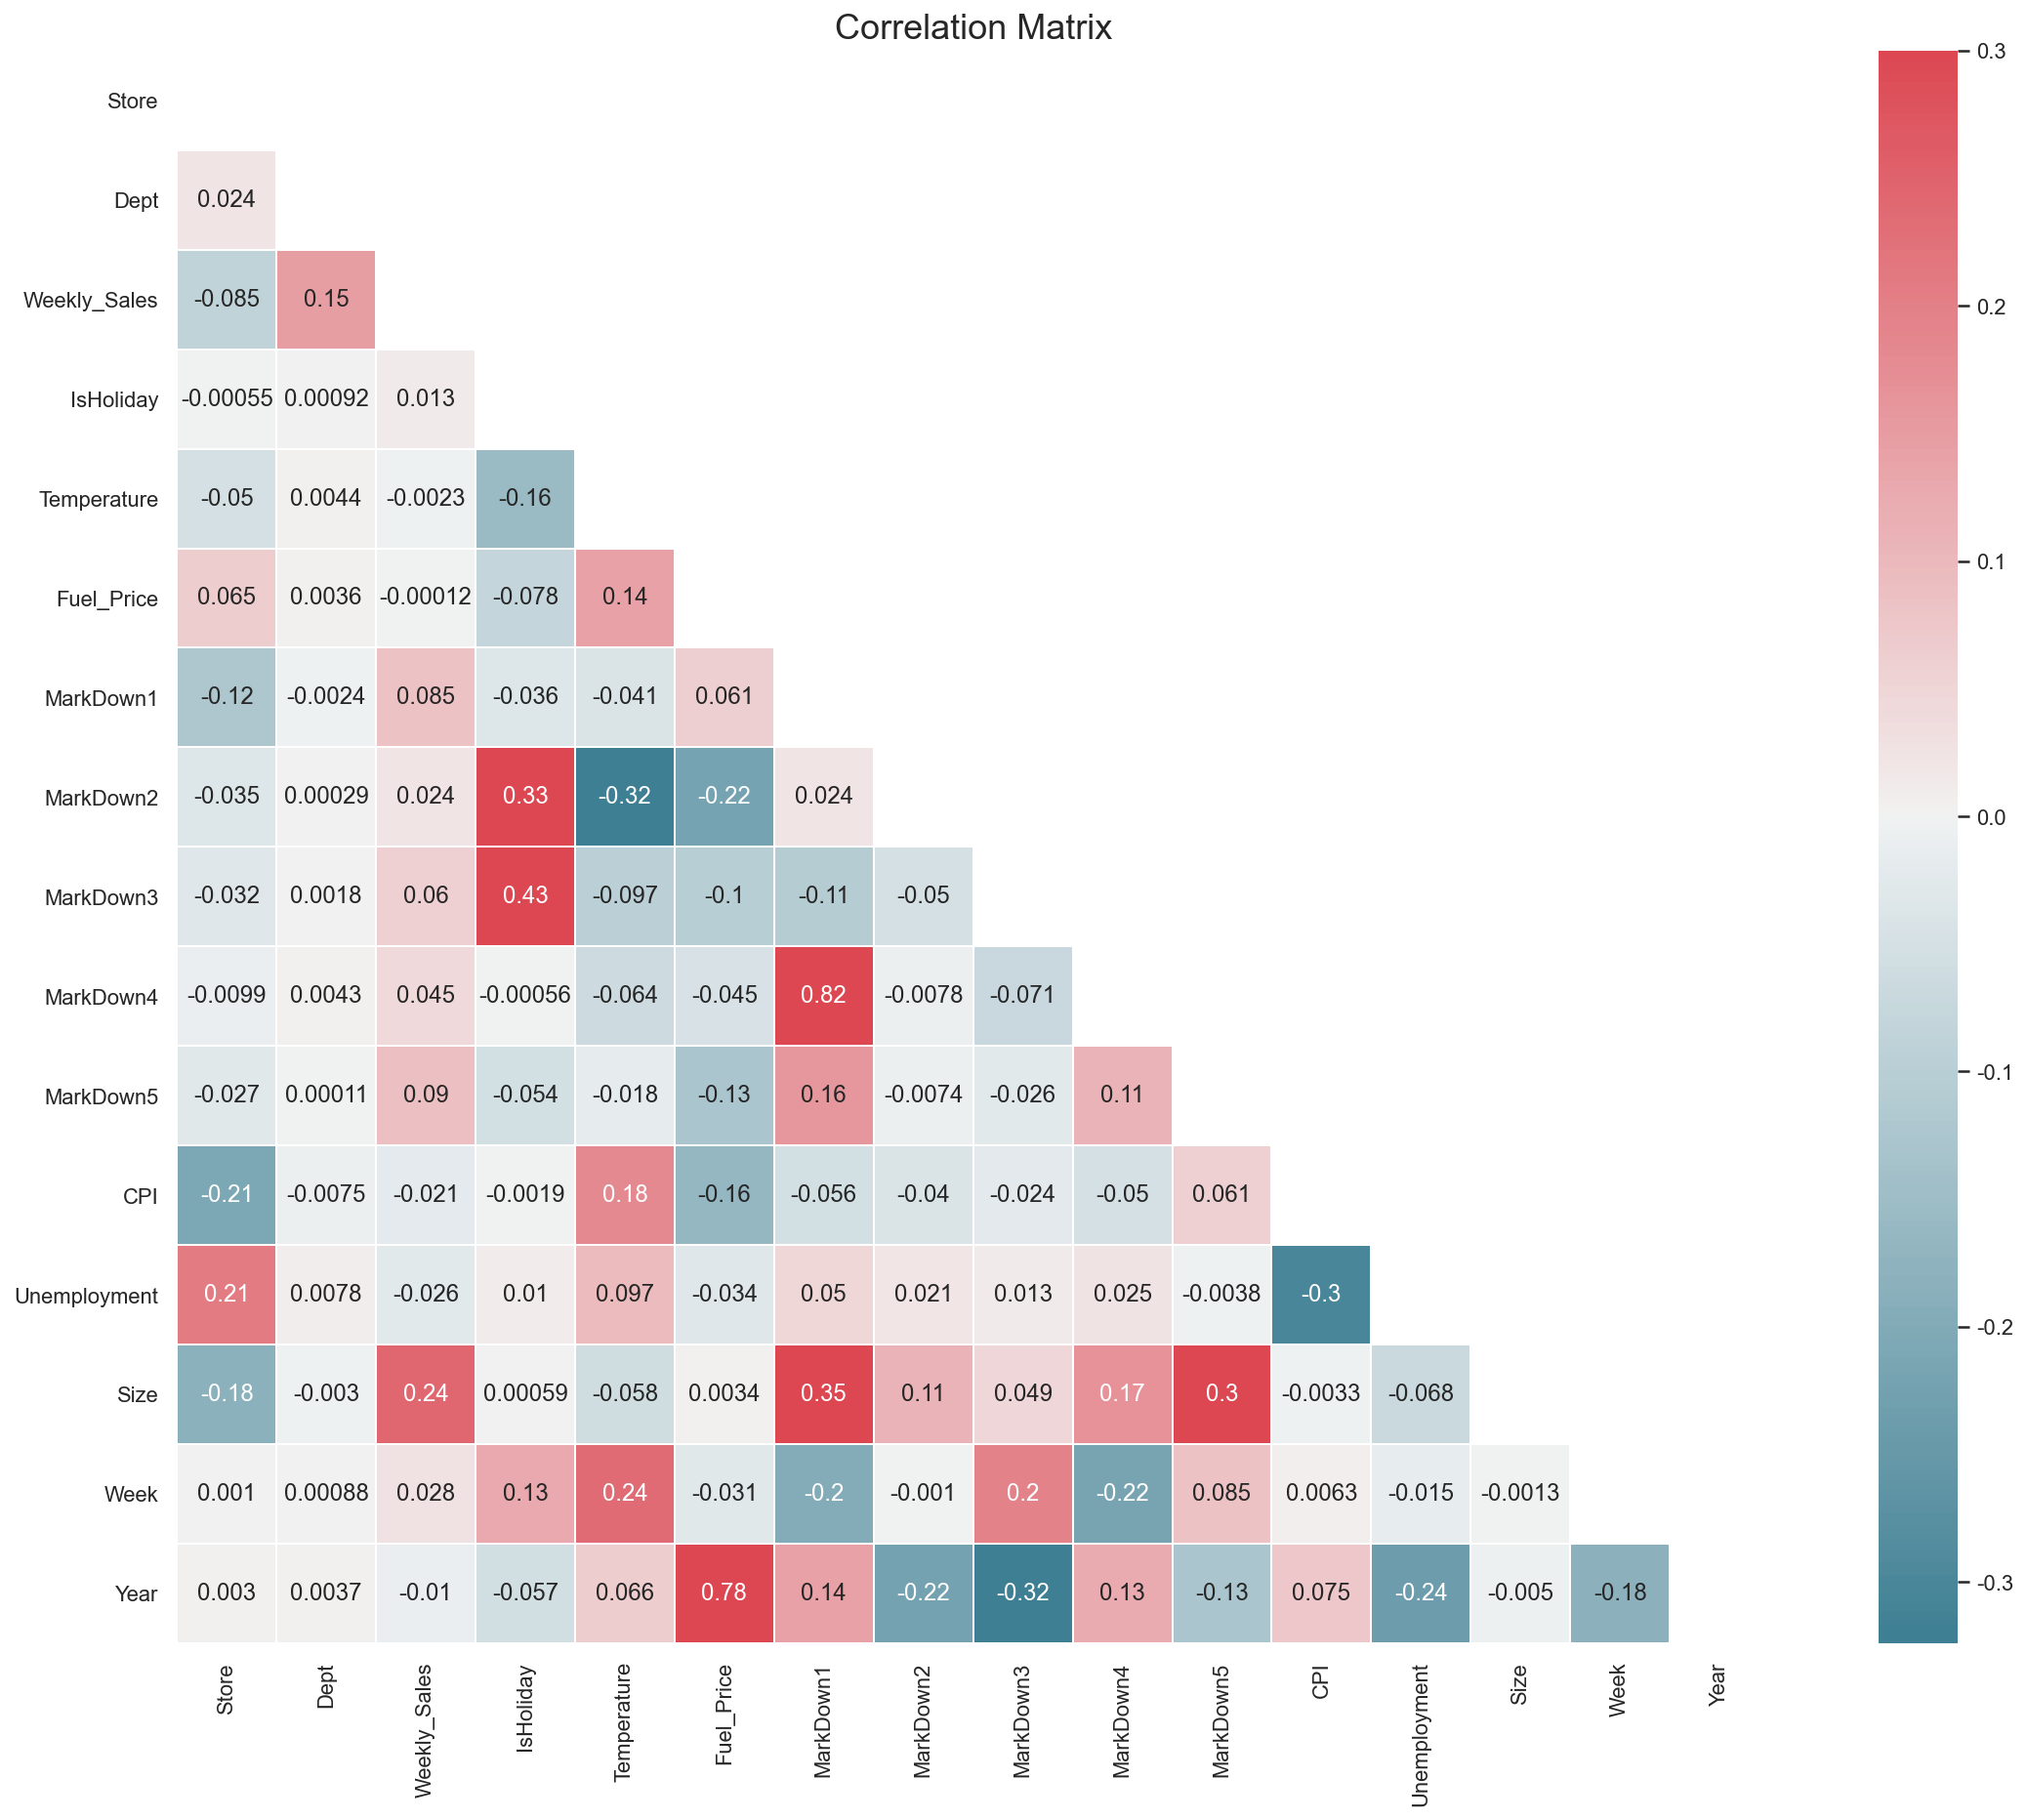

In [20]:
# 상관관계 그래프 나타내기 
sns.set(style='white')
corr = train_detail.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidths=.5, annot=True)
plt.show()

## Markdown1~5과 Fuel_price는 주간 판매량(Weekly_Sales)와 큰 연관관계가 없는 모습을 볼 수 있습니다. 따라서 해당 Feature는 드롭합니다.

In [21]:
train_detail = train_detail.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'])

## Feature 더 자세히 분석하기

### 두가지 plot 함수를 만들어봅시다.
### 먼저 제한된 숫자를 가진 컬럼을 위한 discrete plot을 그립니다. discrete plot 같은 경우, boxplot과 stripplot을 이용해서 그래프를 그립니다.
### 연속된 값을 가진 컬럼을 위한 continuous plot을 그립니다.  cotinuous plot 같은 경우, regplot을 이용해서 그래프를 그립니다.

In [22]:
def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y = train_detail.Weekly_Sales, x = train_detail[feature], ax = fig.add_subplot(gs[0,0]))
    plt.ylabel('판매량(Sales)', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('판매량(Sales)', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [23]:
def make_continuous_plot(feature):
    fig = plt.figure(figsize=(18,15))
    sns.regplot(data=train_detail, x=feature, y='Weekly_Sales', color='green')
    fig.show()

### Weekly_Sales 컬럼과 IsHoliday 컬럼의 상관관계 분석

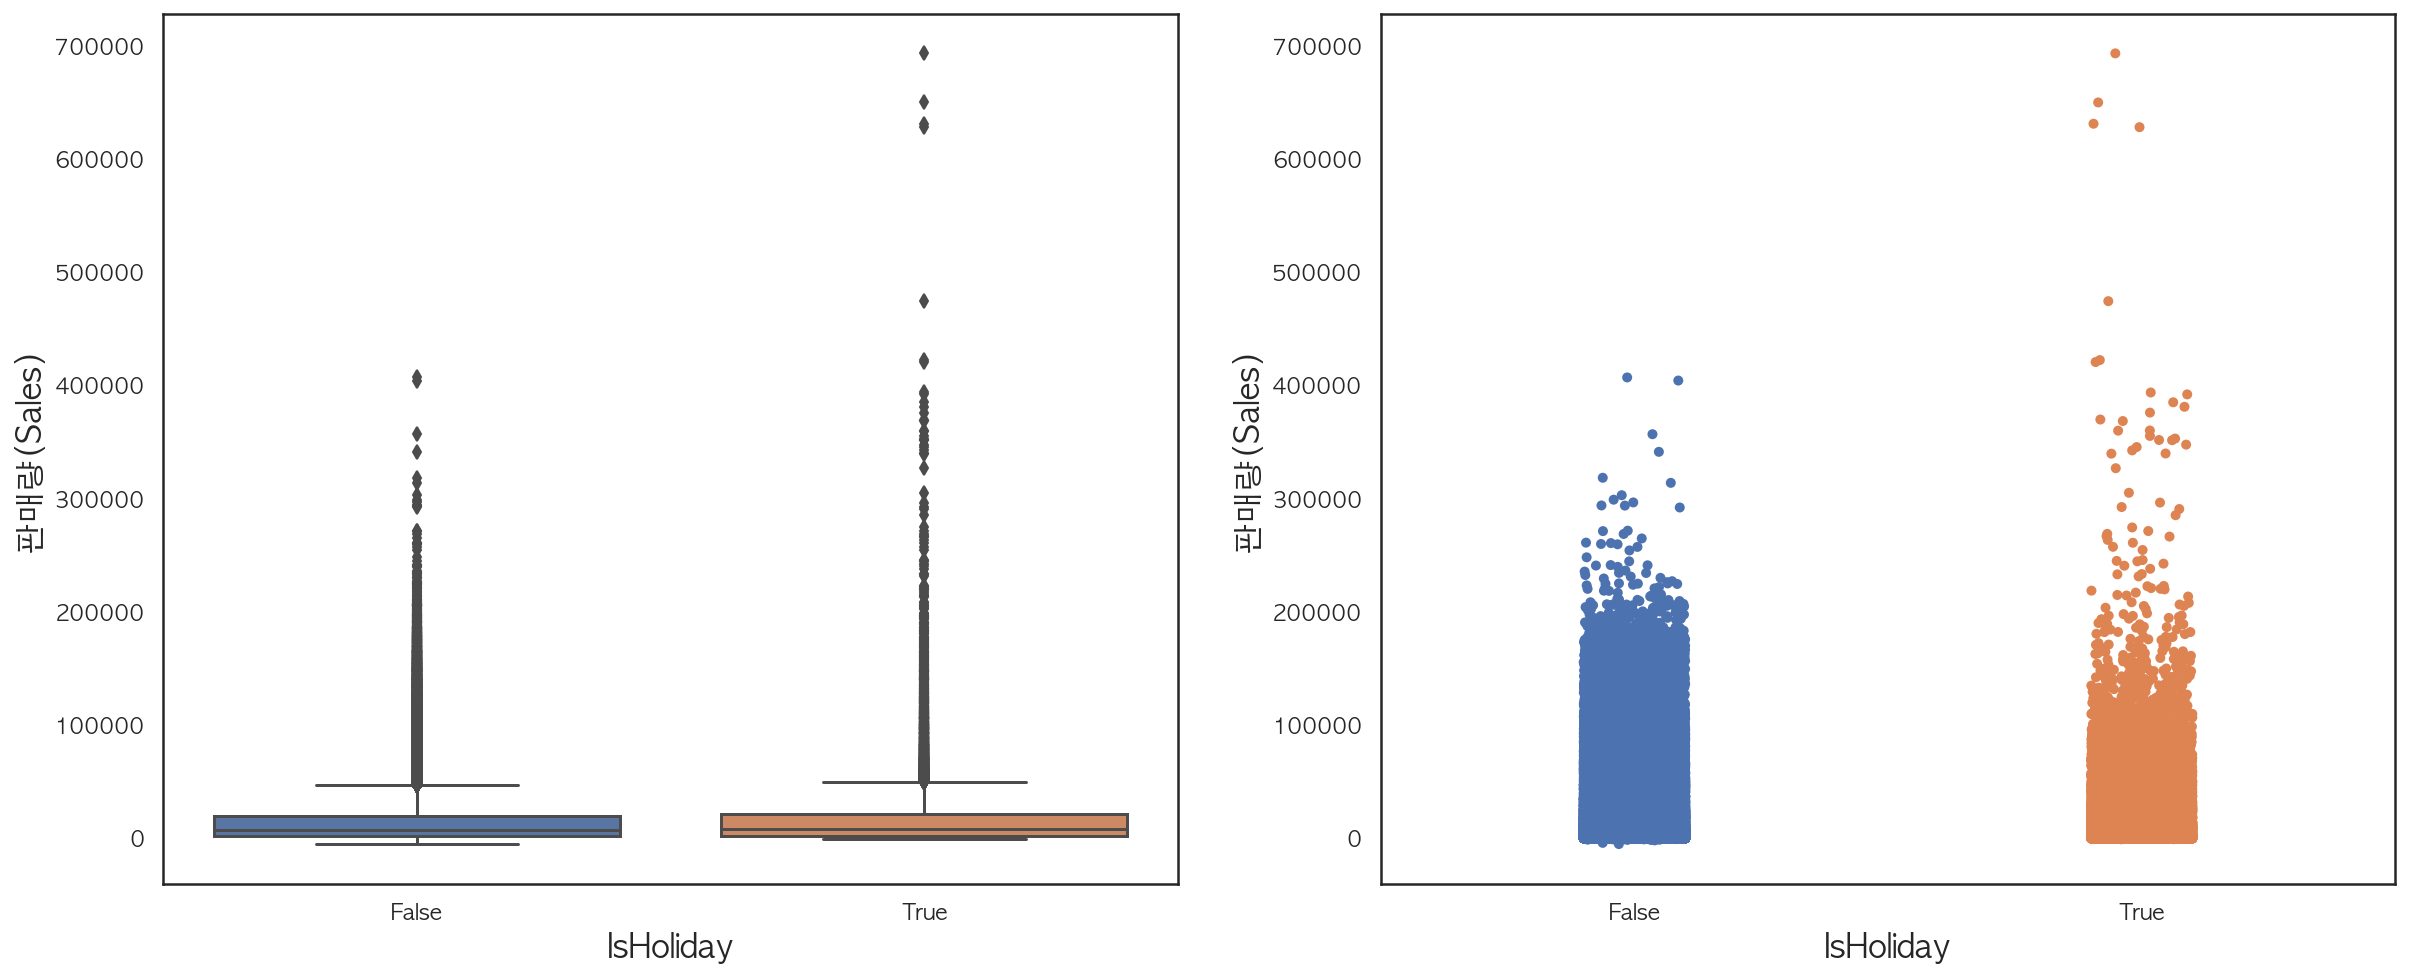

In [26]:
make_discrete_plot('IsHoliday')

### 공휴일 주간에 더욱 많은 판매량을 기록한 데이터들이 존재하는 모습을 볼 수 있습니다.

### Weekly_Sales 컬럼과 Type 컬럼의 상관관계 분석

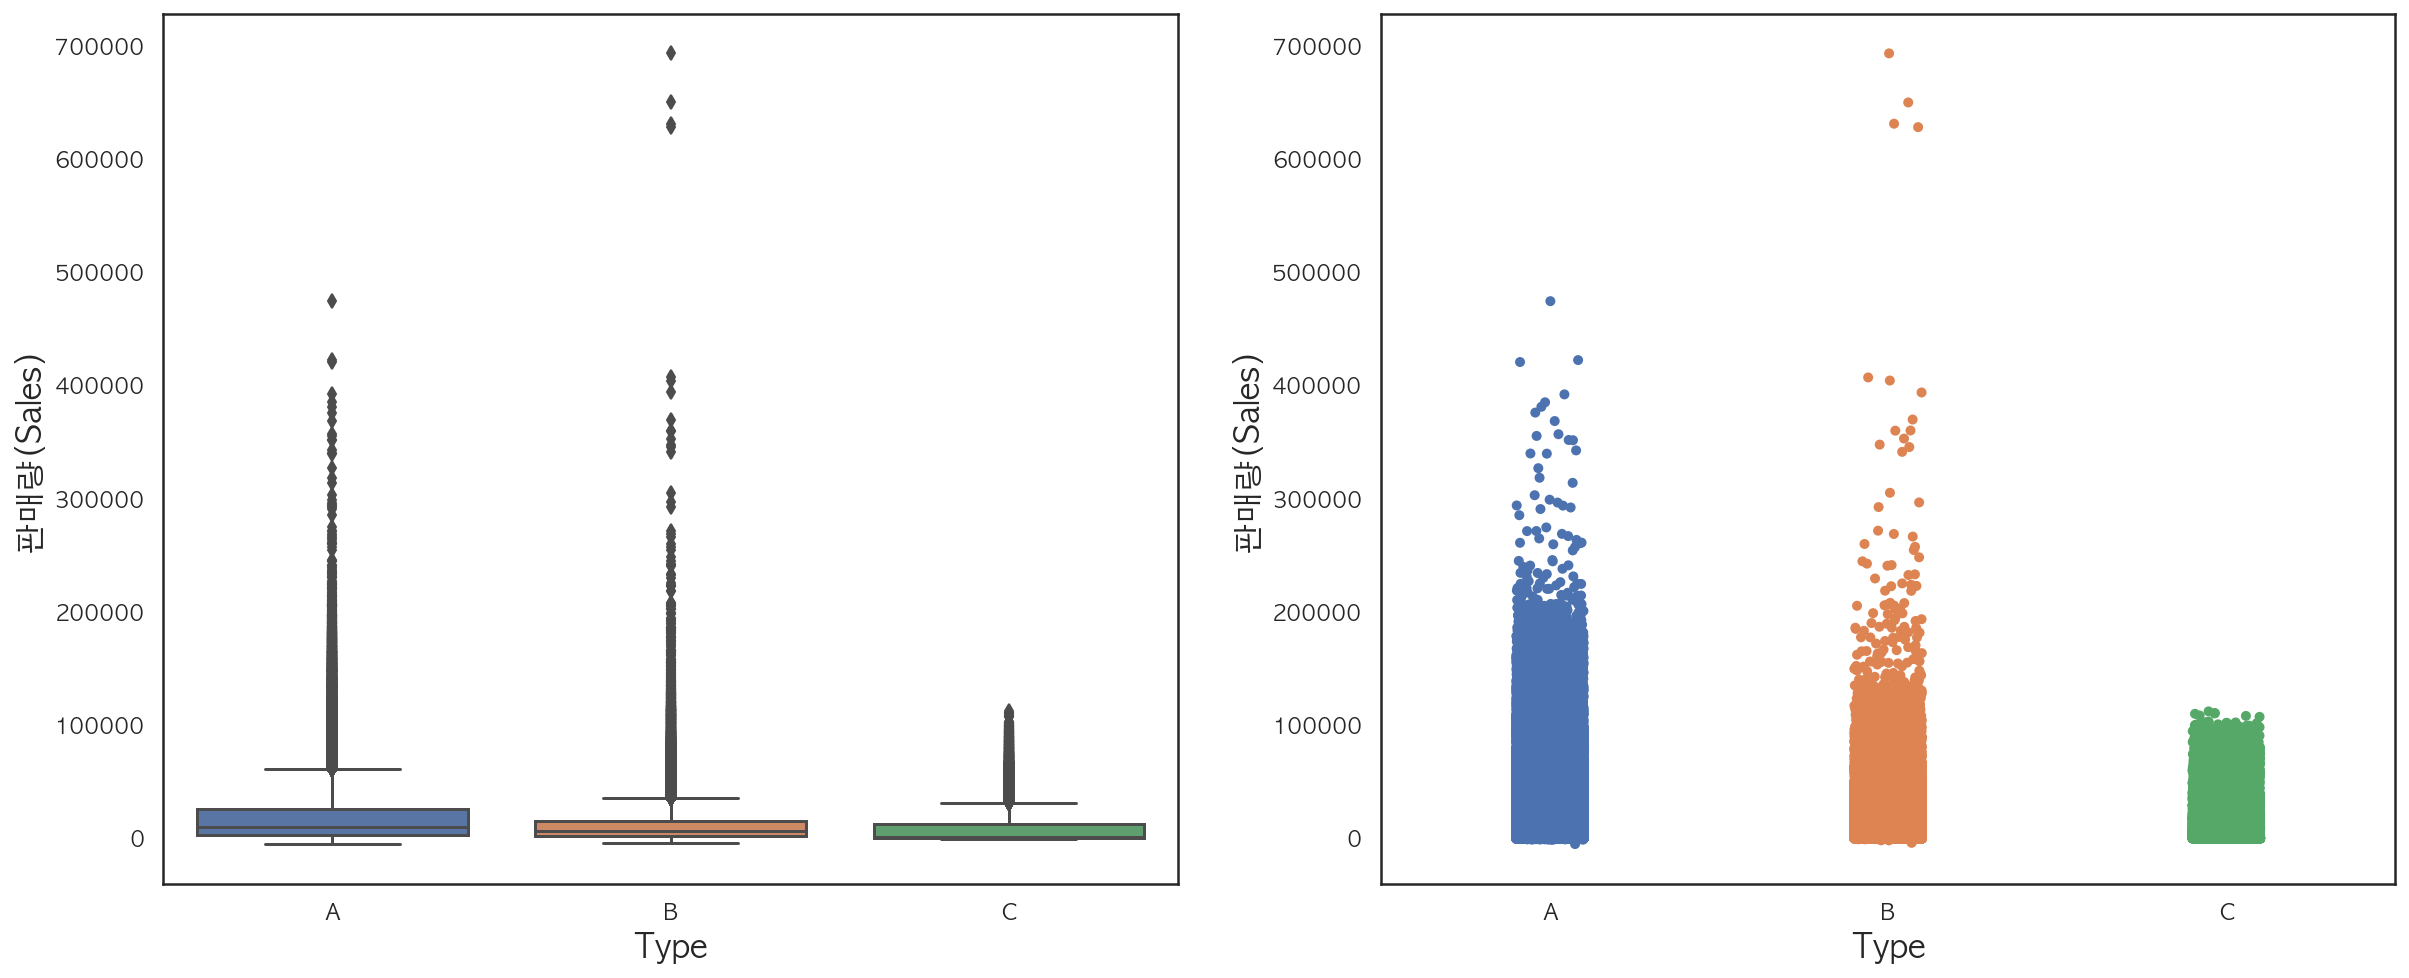

In [27]:
make_discrete_plot('Type')

## Type의 A > B > C 순으로 판매량이 많은 모습을 볼 수 있습니다.

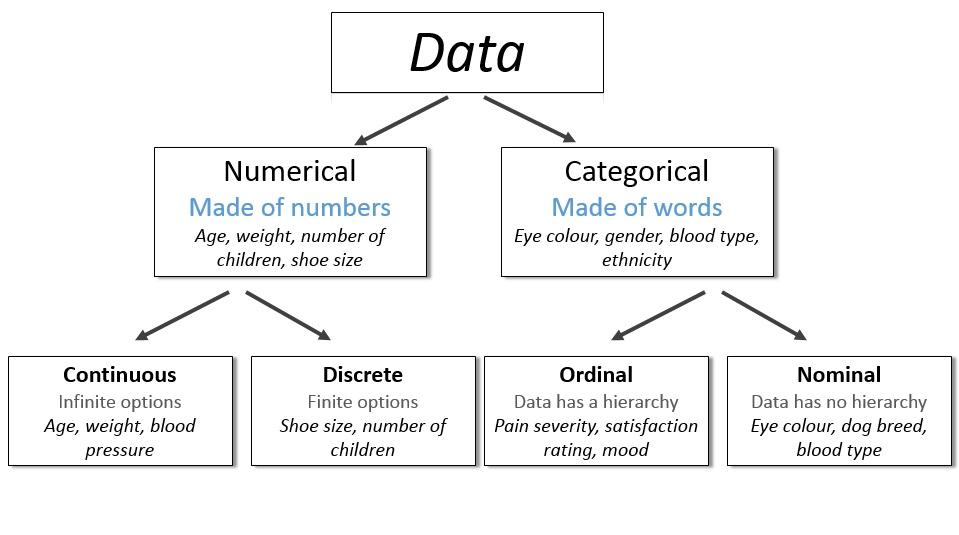

## 따라서 Type 컬럼을 Ordinal 형태로 변경합니다.

In [29]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

### Weekly_Sales 컬럼과 Temperature 컬럼의 상관관계 분석

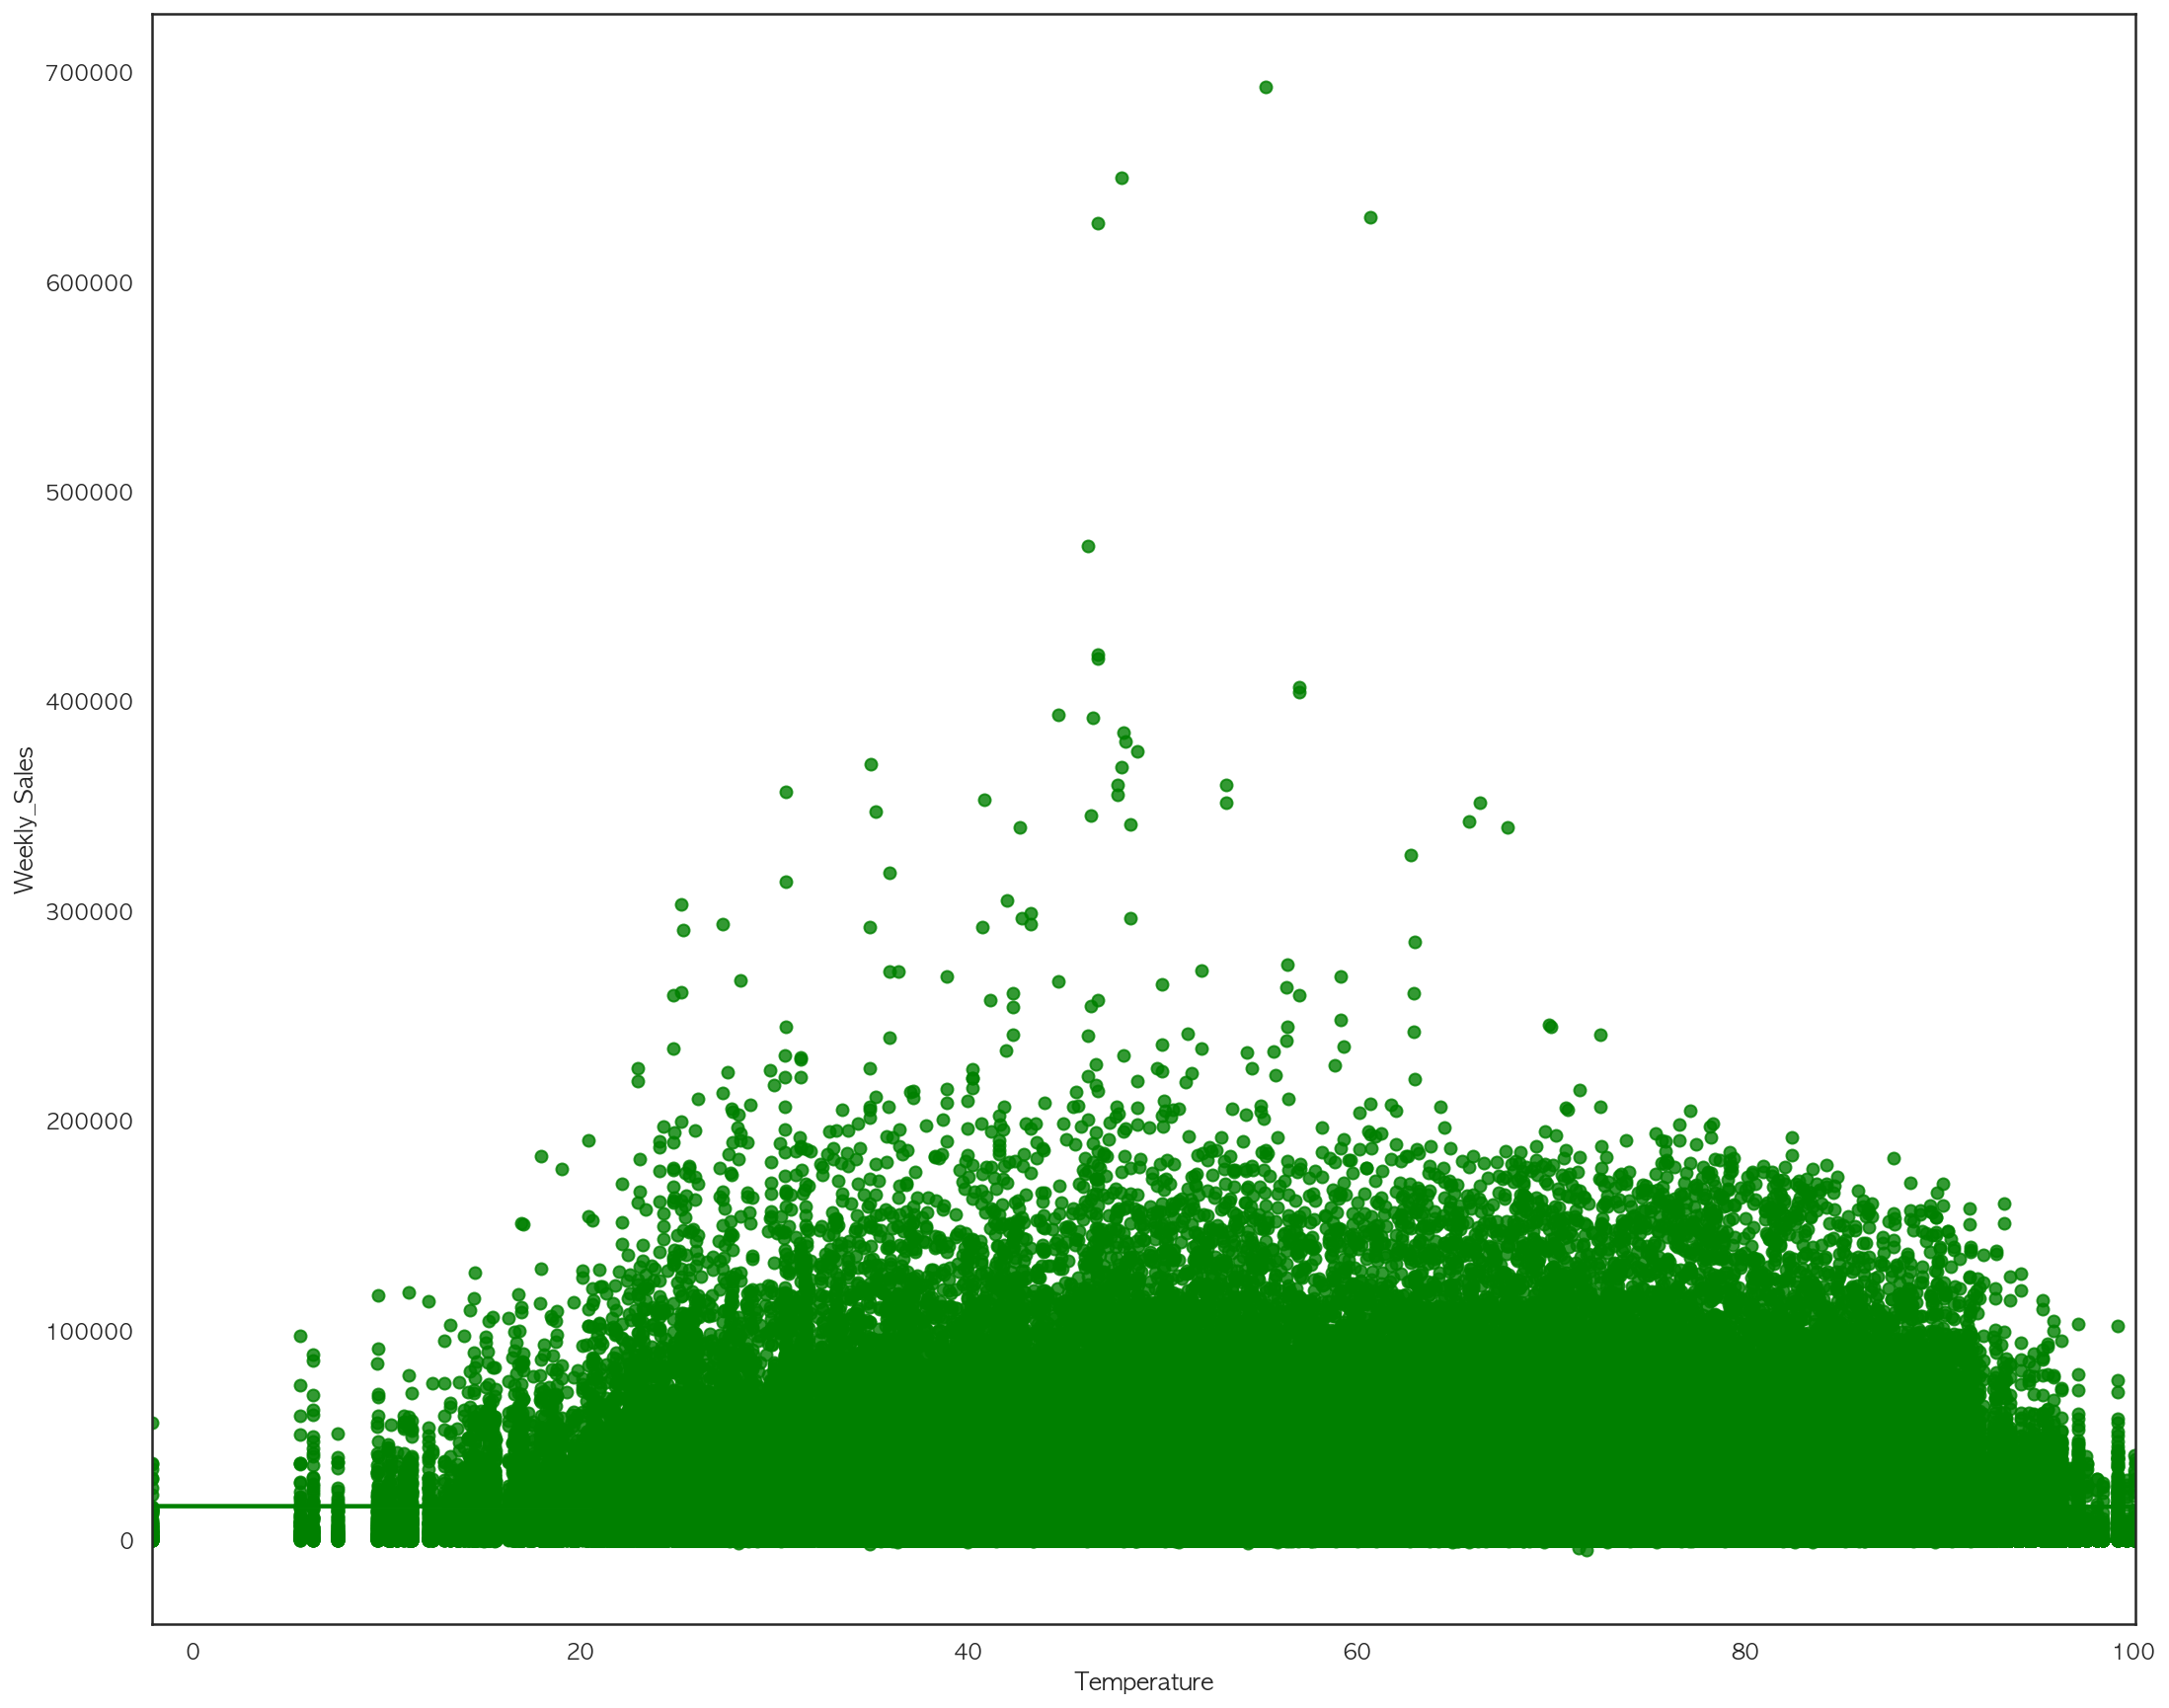

In [31]:
make_continuous_plot('Temperature')

## Temperatue는 판매량과 연관관계가 거의 없는 모습을 볼 수 있습니다. 따라서 해당 Feature를 drop합니다.

In [32]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

### Weekly_Sales 컬럼과 CPI 컬럼의 상관관계 분석

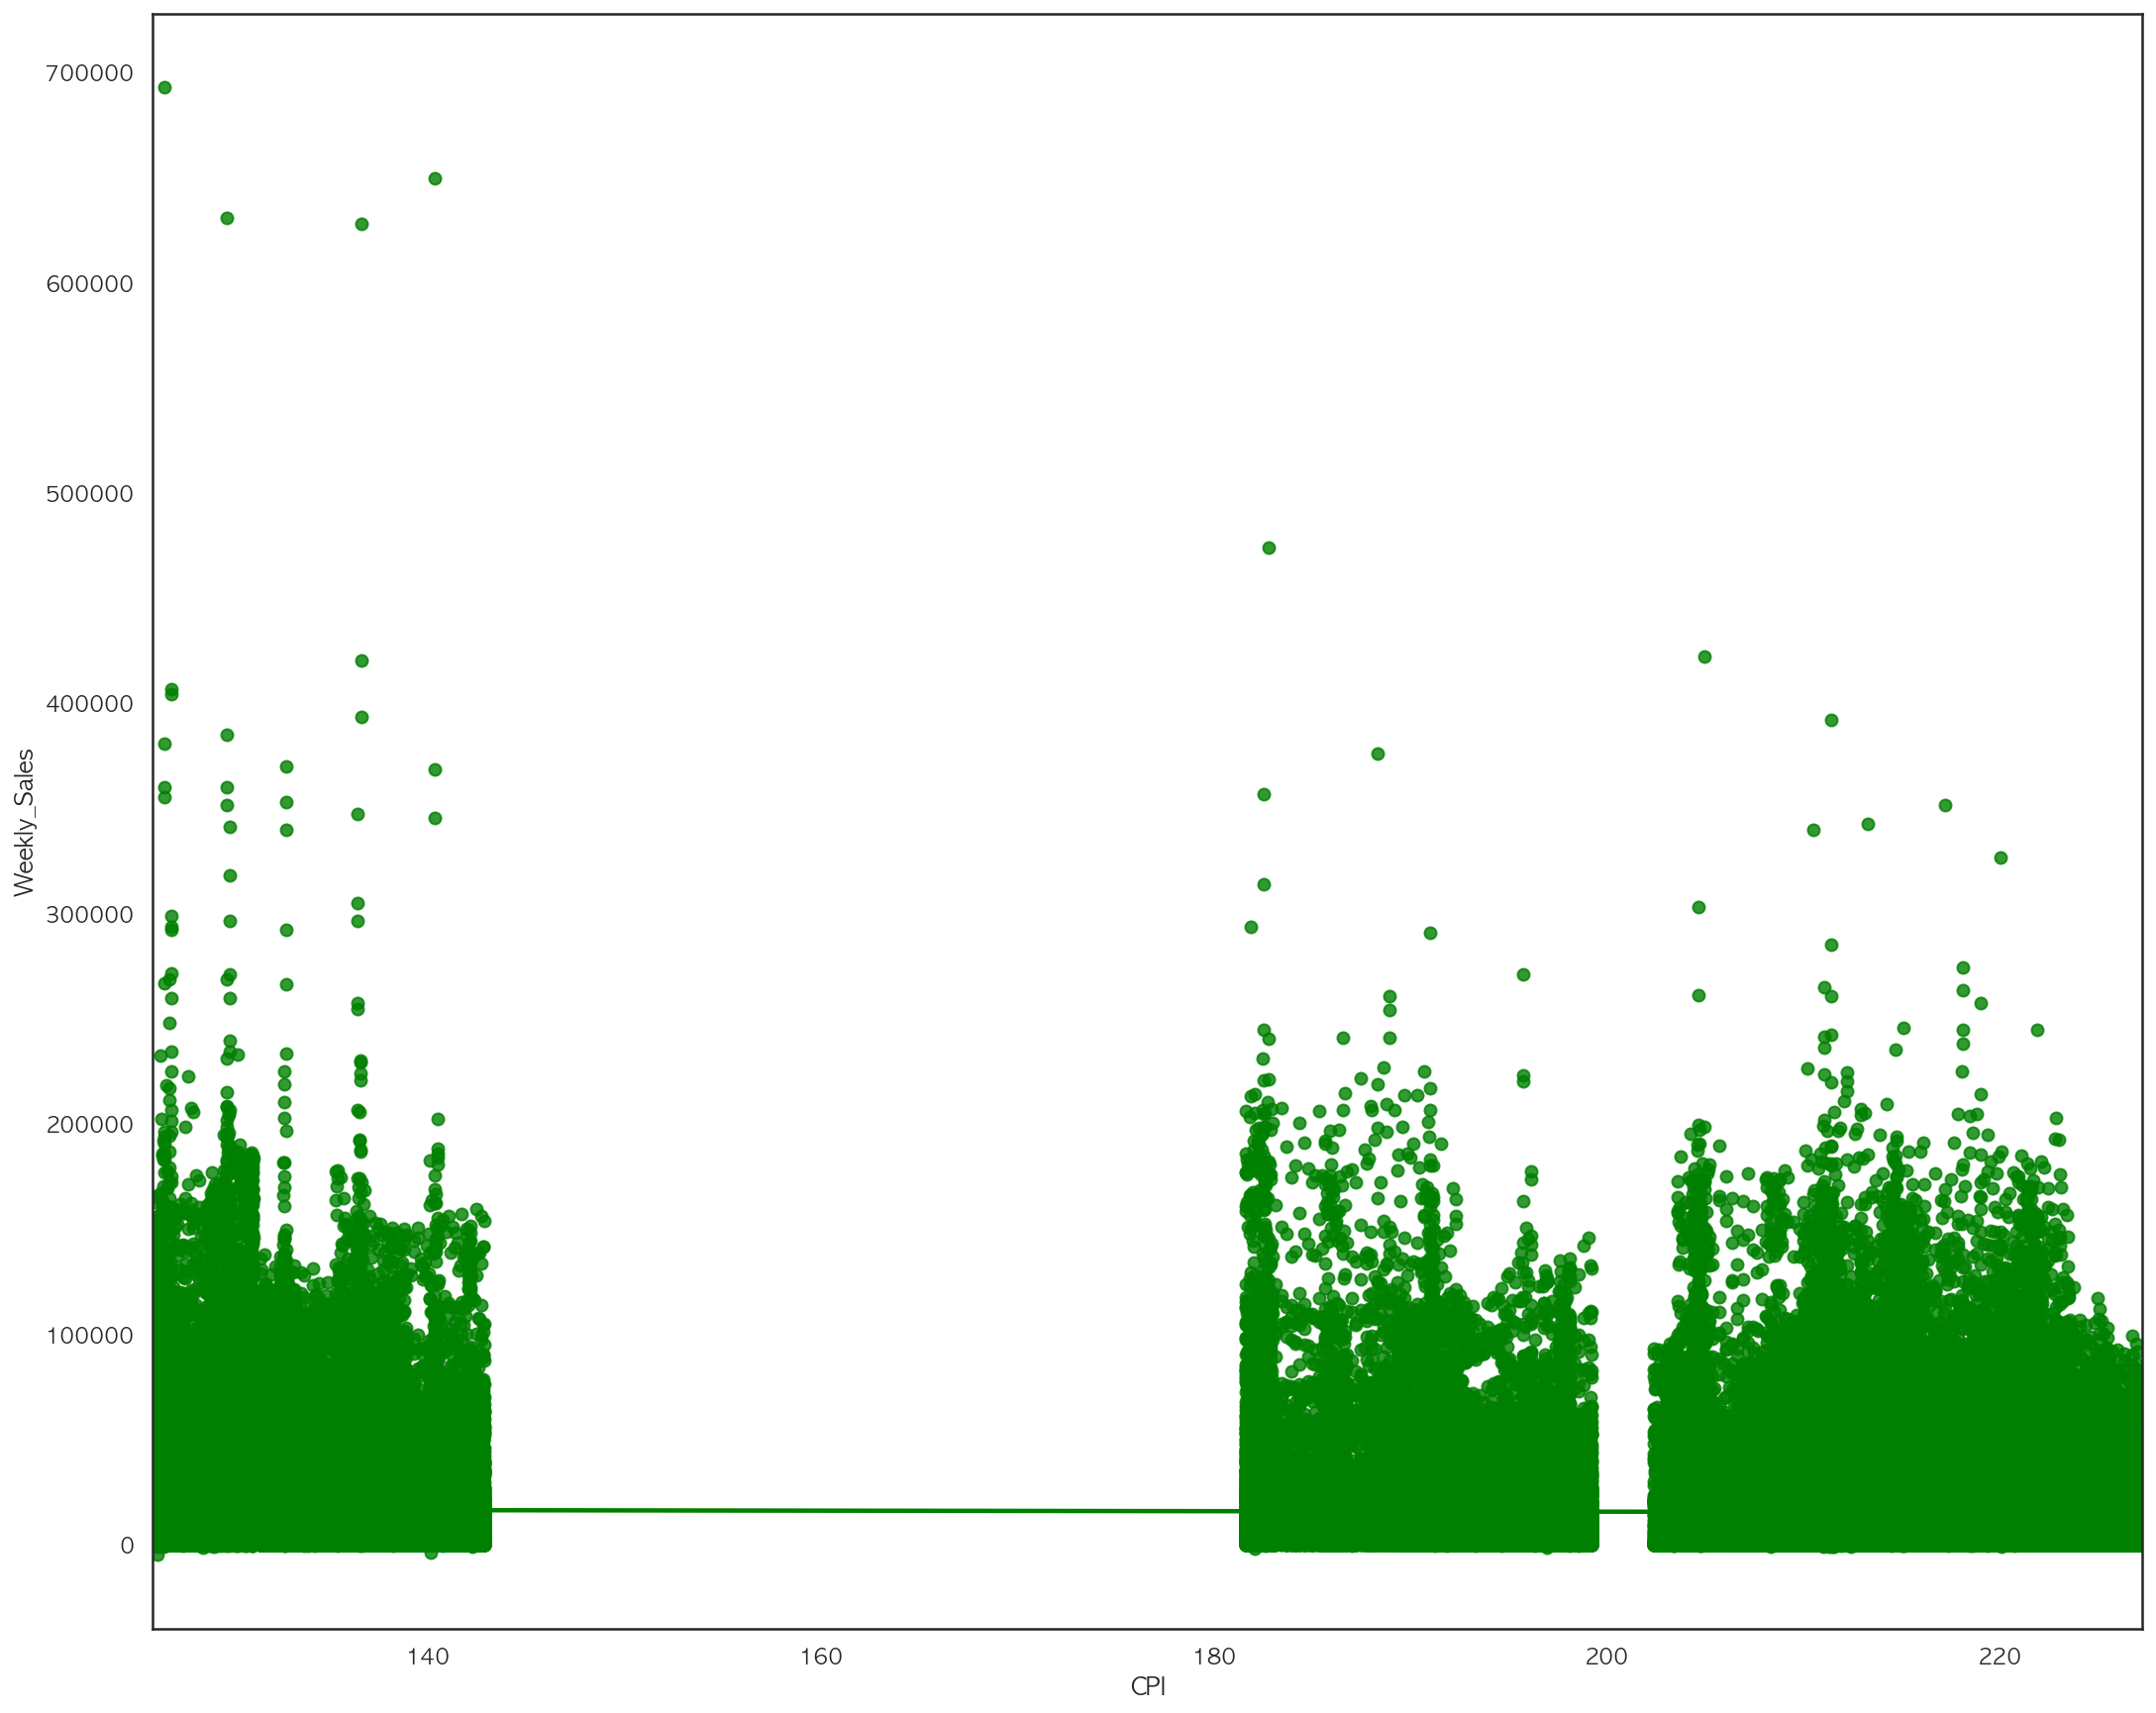

In [33]:
make_continuous_plot('CPI')

## CPI 또한 판매량과 연관관계가 거의 없는 모습을 볼 수 있습니다. 따라서 해당 Feature를 drop합니다.

In [34]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

### Weekly_Sales 컬럼과 Unemployment 컬럼의 상관관계 분석

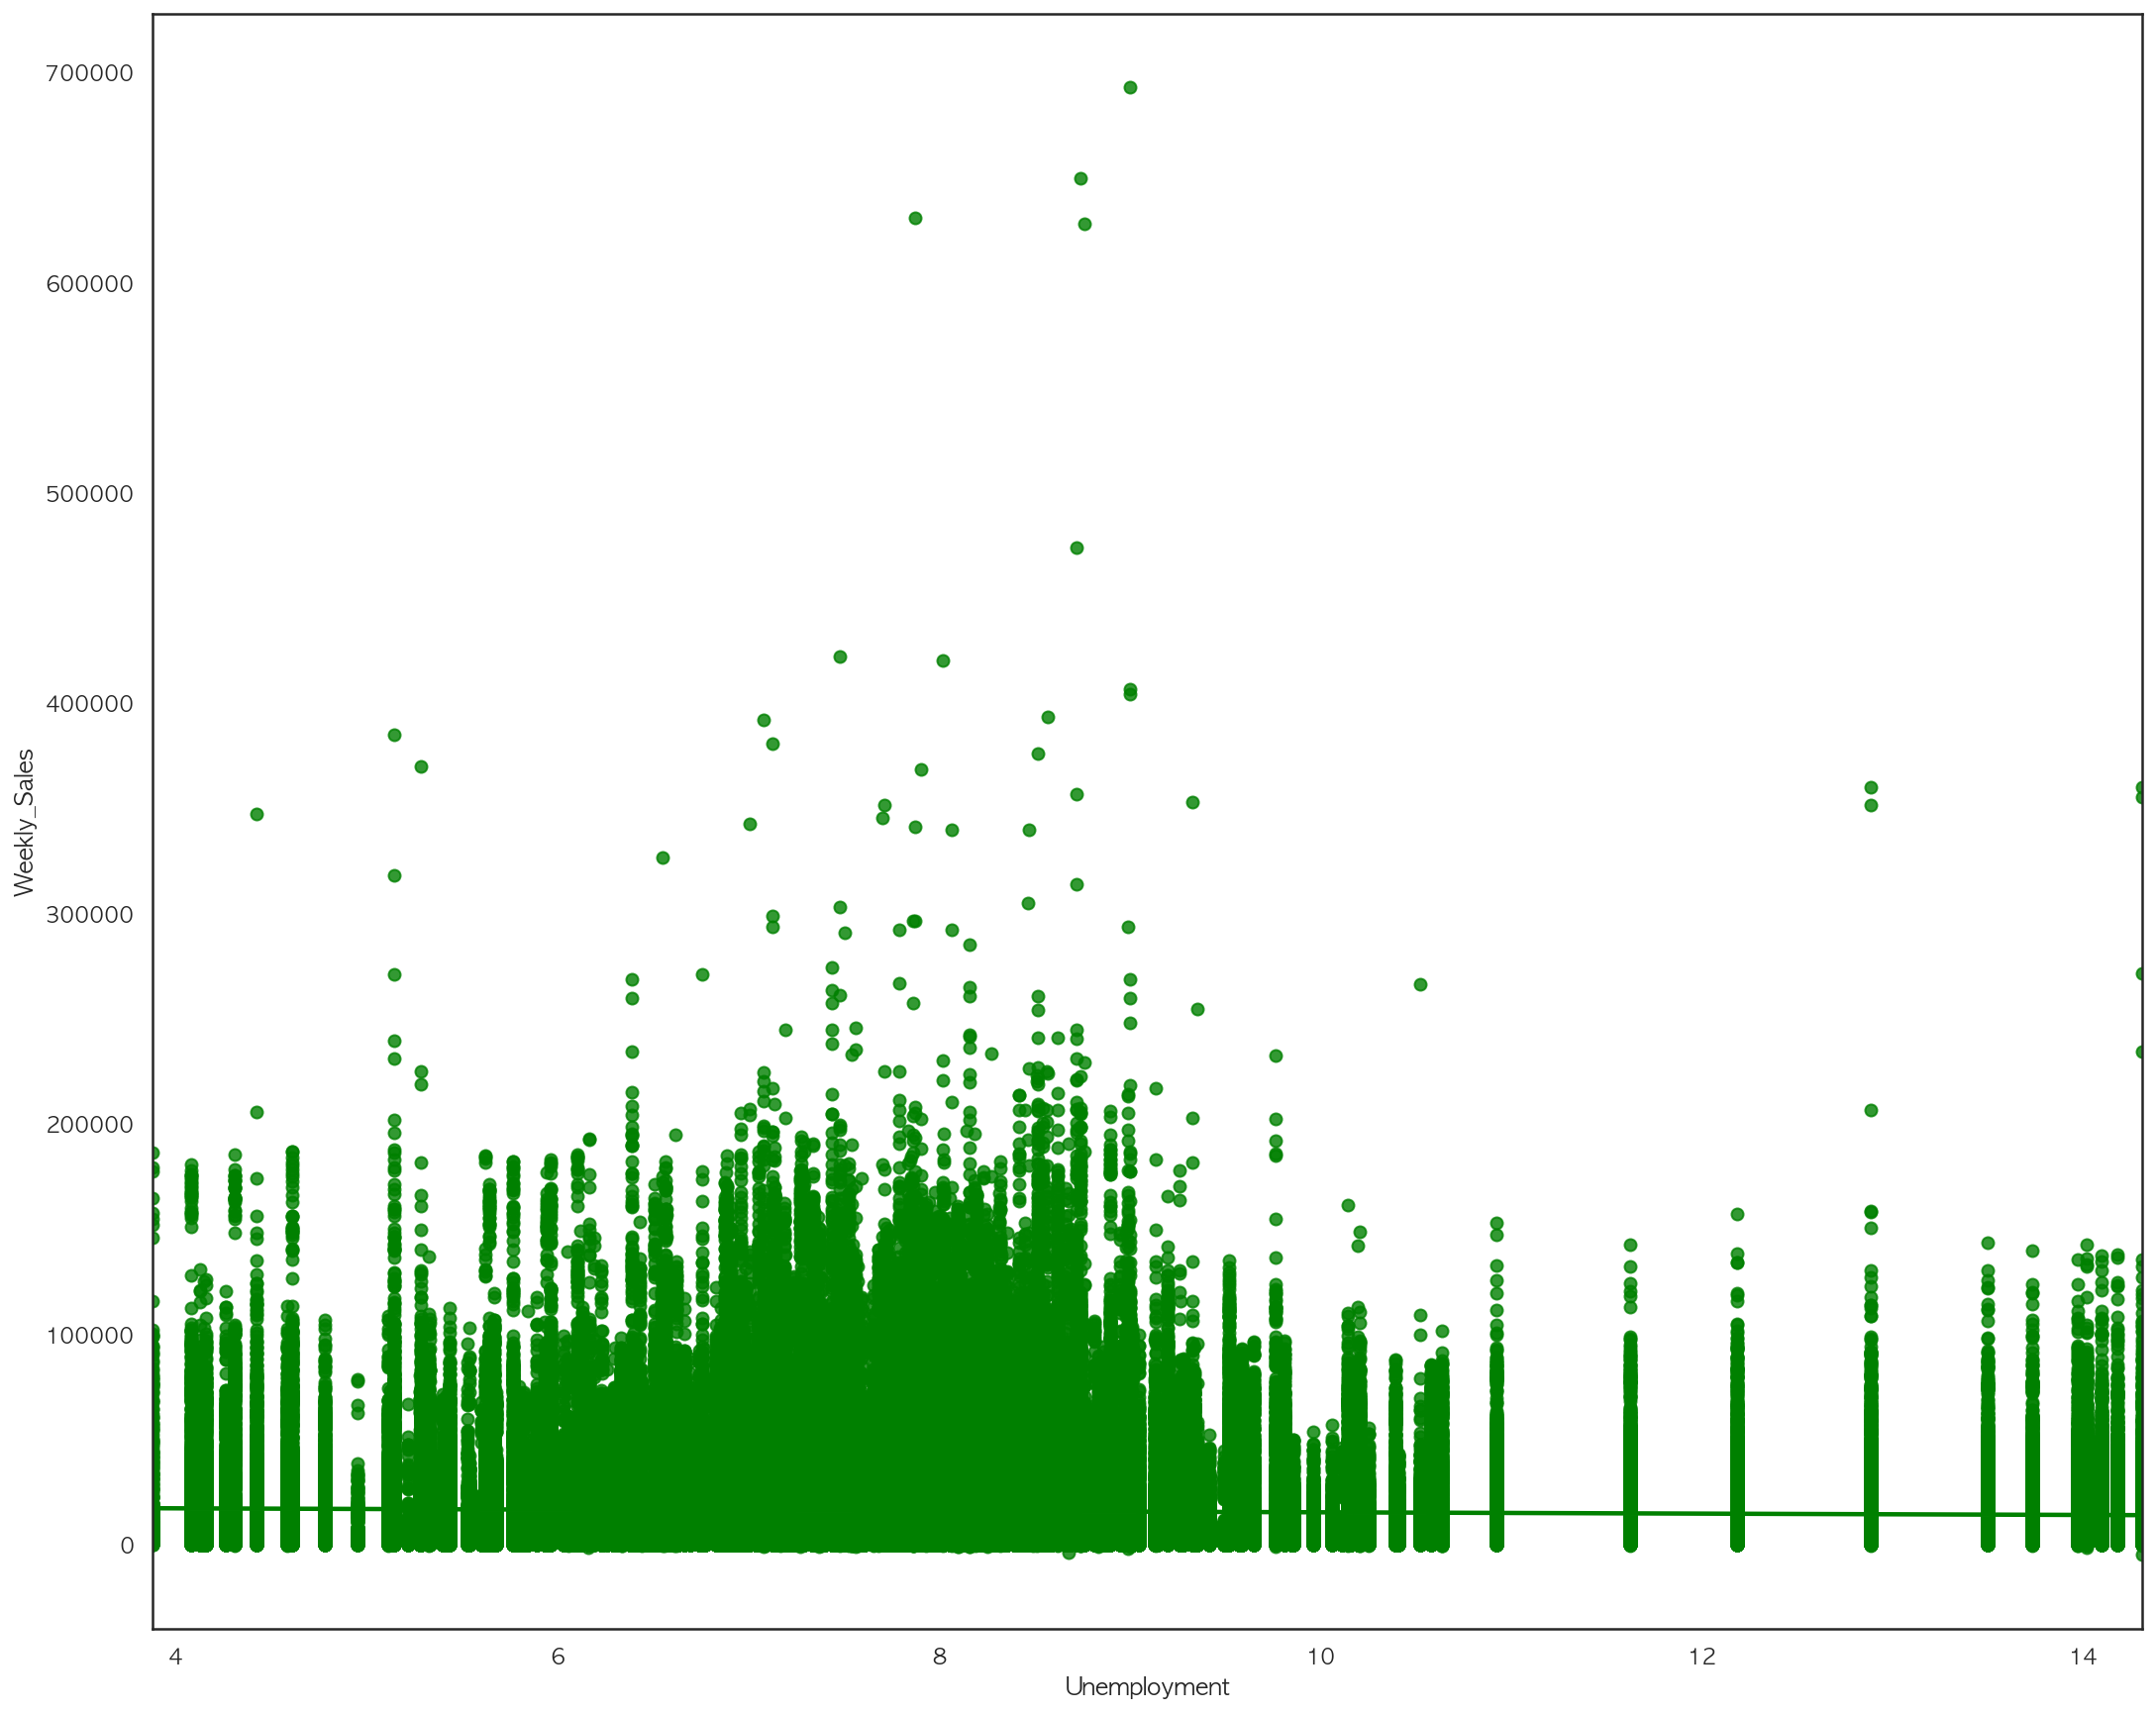

In [35]:
make_continuous_plot('Unemployment')

## Unemployment 또한 판매량과 연관관계가 거의 없는 모습을 볼 수 있습니다. 따라서 해당 Feature를 drop합니다.

In [36]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

### Weekly_Sales 컬럼과 Size 컬럼의 상관관계 분석

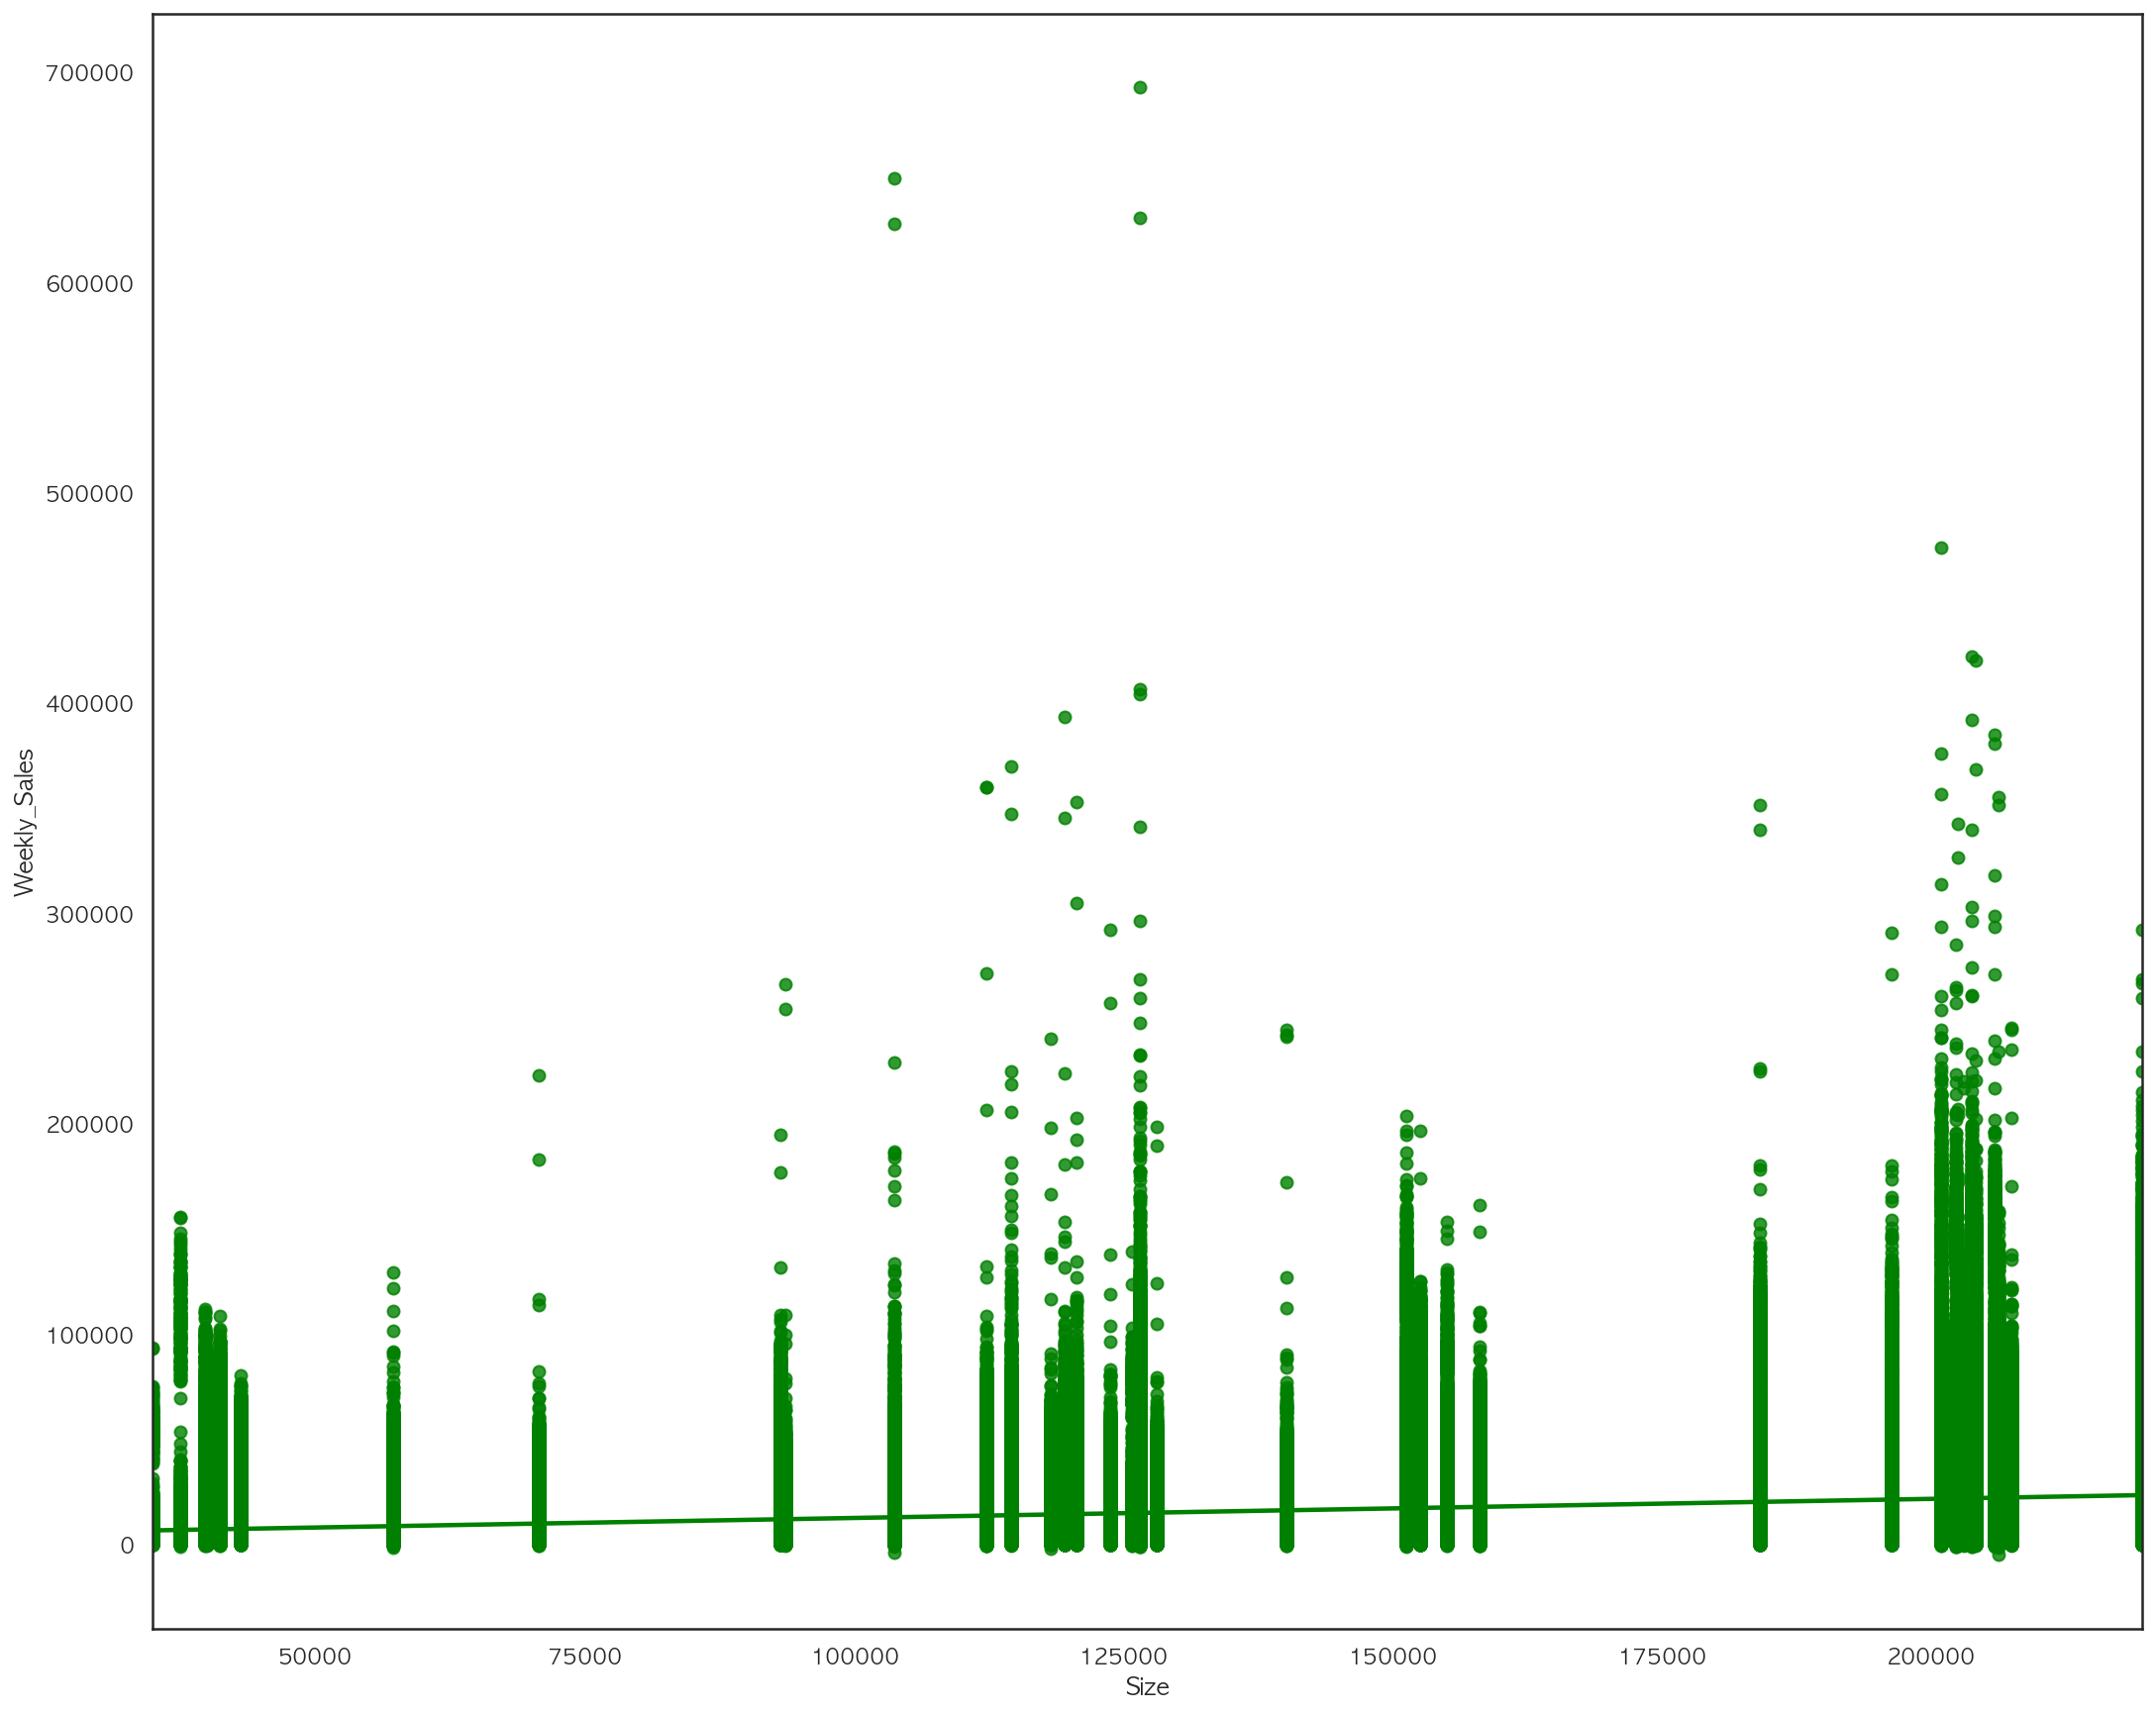

In [38]:
make_continuous_plot('Size')

## Size는 판매량과 연관관계를 가지고 있는 모습을 볼 수 있습니다.

# 3. 머신러닝을 이용한 예측 모델 생성

> 아래 그림에서 볼 수 있듯이 공휴일이 포함된 주에 5의 가중치를 가지고 에러를 측정합니다.

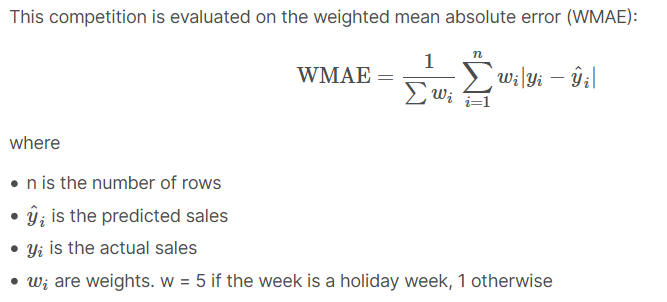

## 따라서 WMAE 손실함수를 다음과 같이 정의합니다.

In [40]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

## 분류기로 RandomForesRegressor를 활용합니다. 

## 트레이닝 데이터를 준비합니다.

In [41]:
train_detail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,3,151315,5,2010
1,1,1,2010-02-12,46039.49,True,3,151315,6,2010
2,1,1,2010-02-19,41595.55,False,3,151315,7,2010
3,1,1,2010-02-26,19403.54,False,3,151315,8,2010
4,1,1,2010-03-05,21827.90,False,3,151315,9,2010
...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,2,118221,39,2012
421566,45,98,2012-10-05,628.10,False,2,118221,40,2012
421567,45,98,2012-10-12,1061.02,False,2,118221,41,2012
421568,45,98,2012-10-19,760.01,False,2,118221,42,2012


In [42]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

## Random Forest Estimator를 선언하고 학습 및 예측을 진행합니다.

In [43]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
RF = RandomForestRegressor()
RF.fit(x_train, y_train)
predicted = RF.predict(x_test)

## 트레이닝 에러를 측정합니다.

In [44]:
print('WMAE:', WMAE(x_test, y_test, predicted))

WMAE: 1480.37


### 테스트 데이터에 대한 예측 수행하기(Predictions)

In [47]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

# 4. 대회제출용 csv 데이터 만들기(Submission)

In [49]:
sample_submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0


In [50]:
sample_submission['Weekly_Sales'] = predict
sample_submission.to_csv('submission.csv', index=False)

In [54]:
sample_submission

,Id,Weekly_Sales
0,1_1_2012-11-02,34685.2195
1,1_1_2012-11-09,20013.0462
2,1_1_2012-11-16,20087.2373
3,1_1_2012-11-23,20588.9691
4,1_1_2012-11-30,26638.5490
...,...,...
115059,45_98_2013-06-28,671.6524
115060,45_98_2013-07-05,667.4838
115061,45_98_2013-07-12,699.6955
115062,45_98_2013-07-19,788.6526
